In [ ]:
!pip -q install pyreadstat unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.5 MB/s eta 0:00:00


## Imports y configuración global

In [ ]:
import os, re, json, unicodedata, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
try:
    import pyreadstat  # para .sav
except Exception as e:
    pyreadstat = None
    warnings.warn("pyreadstat no está disponible; no se podrán leer .sav", RuntimeWarning)

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)
plt.rcParams["figure.figsize"] = (6,4)
sns.set(style="whitegrid")

# Utilidad de impresión
def info_df(nombre, df):
    print(f"[{nombre}] {df.shape[0]:,} filas × {df.shape[1]} columnas | nulos:% {df.isna().mean().mean():.2%}")
    print("  ▶ Columnas:", ", ".join(df.columns[:12]), ("..." if df.shape[1] > 12 else ""))


## Montar Drive y rutas

In [ ]:
drive.mount('/content/drive')
BASE_DIR = "/content/drive/MyDrive/Base_datos"

FILES = [
    "CarteraTotalCategoria.csv",
    "CarteraTotalCategoria2.csv",
    "CarteraTotalGenero.csv",
    "CarteraTotalMoneda.csv",
    "CarteraTotalCIC.csv",
    "PrestamosEnero2024.csv",
]


Mounted at /content/drive


## Helpers de nombres/limpieza/tipos

In [ ]:
def to_snake(s: str) -> str:
    if s is None:
        return s
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    s = re.sub(r"[^\w]+", "_", s.strip().lower())
    s = re.sub(r"_+", "_", s).strip("_")
    return s

CANON_MAP =
 {
    # id / fechas
    "_id":"id","id":"id","fechareporte":"fecha_reporte","fecha_reporte":"fecha_reporte","fecha":"fecha_reporte",
    # institución
    "tipoinstitucion":"tipo_institucion","tipo_institucion":"tipo_institucion",
    "codigotipo":"codigo_tipo","codigo_tipo":"codigo_tipo","codigotipoinstitucion":"codigo_tipo",
    # métricas cartera
    "saldocartera":"saldo_cartera","saldo_cartera":"saldo_cartera",
    "nooperaciones":"no_operaciones","no_operaciones":"no_operaciones","cantidad":"cantidad",
    # categorizaciones
    "categoria":"categoria","tipo":"categoria","tipo_credito":"tipo_credito","tipocredito":"tipo_credito",
    "tipo_persona":"tipo_persona","tipopersona":"tipo_persona","moneda":"moneda","cic":"cic",
    # demografía
    "sexo":"sexo","genero":"sexo"
}

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols = [CANON_MAP.get(to_snake(str(c)), to_snake(str(c))) for c in df.columns]
    df = df.copy()
    df.columns = cols
    # desambiguación si quedó duplicado
    if len(set(df.columns)) != len(df.columns):
        counts, fixed = {}, []
        for c in df.columns:
            if c not in counts: counts[c]=0; fixed.append(c)
            else: counts[c]+=1; fixed.append(f"{c}__{counts[c]}")
        df.columns = fixed
    return df

def basic_tidy(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.select_dtypes(include="object").columns:
        s = df[c].astype(str).str.strip()
        df[c] = s.replace({"": np.nan, "nan": np.nan, "None": np.nan})
    return df.drop_duplicates()

def parse_dates_flex(df: pd.DataFrame, date_cols=("fecha_reporte",)) -> pd.DataFrame:
    df = df.copy()
    for c in date_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
    return df

def coerce_numeric(df: pd.DataFrame, prefer_cols=("saldo_cartera","no_operaciones","cantidad","cic")) -> pd.DataFrame:
    df = df.copy()
    patt = re.compile(r"(monto|saldo|no_|cantidad|cifra|importe|total|tasa|renta|ingreso|egreso|cic)$")
    maybe = [c for c in df.columns if c in prefer_cols or patt.search(c or "") ]
    for c in maybe:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def summarize_missing(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum().rename("n_missing").to_frame()
    miss["pct_missing"] = (miss["n_missing"]/len(df)*100).round(2)
    miss["dtype"] = df.dtypes.astype(str)
    return miss

def winsorize_df(df: pd.DataFrame, lower=0.01, upper=0.99):
    dfw, bounds = df.copy(), {}
    for c in dfw.select_dtypes(include=[np.number]).columns:
        lo, hi = dfw[c].quantile(lower), dfw[c].quantile(upper)
        dfw[c] = dfw[c].clip(lo, hi)
        bounds[c] = {"p_low": float(lo), "p_high": float(hi)}
    return dfw, bounds


NameError: name 'pd' is not defined

## Lectura robusta (CSV/XLSX/SAV) + carga masiva

In [ ]:
def smart_read(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":
        return pd.read_csv(path, encoding="utf-8", low_memory=False)
    if ext in (".xls", ".xlsx"):
        return pd.read_excel(path)
    if ext == ".sav":
        if pyreadstat is None:
            raise ImportError("pyreadstat no instalado para leer .sav")
        df, meta = pyreadstat.read_sav(path, apply_value_formats=True)
        return df
    raise ValueError(f"Extensión no soportada: {ext}")

loaded = {}
errores = {}
for fname in FILES:
    fpath = os.path.join(BASE_DIR, fname)
    try:
        df = smart_read(fpath)
        df = normalize_columns(basic_tidy(df))
        df = parse_dates_flex(df, date_cols=("fecha_reporte","fecha"))
        df = coerce_numeric(df)
        loaded[fname] = df
        print(f"[OK] {fname}: {df.shape[0]:,} filas × {df.shape[1]} cols")
    except Exception as e:
        errores[fname] = str(e)
        print(f"[ERROR] {fname} -> {e}")

if errores:
    print("\nArchivos con error de lectura:")
    for k,v in errores.items(): print("  -", k, ":", v)


/tmp/ipython-input-378970575.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)


[OK] CarteraTotalCategoria.csv: 3,400 filas × 7 cols


/tmp/ipython-input-378970575.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)


[OK] CarteraTotalCategoria2.csv: 25,008 filas × 9 cols


/tmp/ipython-input-378970575.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)


[OK] CarteraTotalGenero.csv: 303 filas × 5 cols


/tmp/ipython-input-378970575.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)


[OK] CarteraTotalMoneda.csv: 34,976 filas × 10 cols


/tmp/ipython-input-378970575.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)


[OK] CarteraTotalCIC.csv: 727,139 filas × 14 cols
[OK] PrestamosEnero2024.csv: 58,531 filas × 11 cols


/tmp/ipython-input-378970575.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)


## Faltantes (reporte) + Winsorización

In [ ]:
missing_reports = {name: summarize_missing(df) for name, df in loaded.items()}

# Imputar numéricas
IMPUTAR_NUM = False
if IMPUTAR_NUM:
    for name, df in loaded.items():
        nums = df.select_dtypes(include=[np.number]).columns
        df[nums] = df[nums].apply(lambda s: s.fillna(s.median()))
        loaded[name] = df

# Winsorización
APLICAR_WINSOR = True
winsorized, bounds_all = {}, {}
for name, df in loaded.items():
    if APLICAR_WINSOR:
        dfw, b = winsorize_df(df, lower=0.01, upper=0.99)
        winsorized[name], bounds_all[name] = dfw, b
    else:
        winsorized[name] = df.copy()

print("Winsorización aplicada" if APLICAR_WINSOR else "Sin winsorización")

Winsorización aplicada


## Filtrar valore en género/sexo/tipo_persona

In [ ]:
def descartar_Z_en_genero(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return df
    df2 = df.copy()
    cols = [c for c in df2.columns if c.lower() in ("genero","sexo","tipo_persona")]
    for col in cols:
        mask_z = df2[col].astype(str).str.strip().str.upper().eq("Z")
        if mask_z.any():
            df2 = df2.loc[~mask_z]
    return df2

tablas = {}
for name, df in winsorized.items():
    df2 = descartar_Z_en_genero(df)
    tablas[name] = df2
    diff = len(df) - len(df2)
    if diff:
        print(f"[FILTRADO] {name}: -{diff} filas con 'Z' en género/sexo/tipo_persona")

# Alias
df_categoria  = tablas.get("CarteraTotalCategoria.csv")
df_categoria2 = tablas.get("CarteraTotalCategoria2.csv")
df_genero     = tablas.get("CarteraTotalGenero.csv")
df_moneda     = tablas.get("CarteraTotalMoneda.csv")
df_cic        = tablas.get("CarteraTotalCIC.csv")
df_prestamos  = tablas.get("PrestamosEnero2024.csv")


[FILTRADO] CarteraTotalGenero.csv: -101 filas con 'Z' en género/sexo/tipo_persona


## Utilidades EDA (pick num, hist, heatmap, boxplot)

In [ ]:
def pick_numeric_column(df: pd.DataFrame):
    prioridad = ["saldo_cartera","no_operaciones","cantidad","cic","monto","total"]
    for c in prioridad:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]): return c
    nums = df.select_dtypes(include=[np.number]).columns
    return nums[0] if len(nums) else None

def plot_hist(df, title):
    col = pick_numeric_column(df)
    if not col: return
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histograma de {col} — {title}")
    plt.xlabel(col); plt.ylabel("Frecuencia")
    plt.show()

def plot_heatmap(df, title):
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) < 2: return
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=False, cmap="viridis")
    plt.title(f"Heatmap de correlaciones — {title}")
    plt.tight_layout()
    plt.show()

def _stats_text(x: np.ndarray):
    x = x[~np.isnan(x)]
    if len(x)==0: return "n=0"
    q1, med, q3 = np.percentile(x, [25,50,75])
    mu = np.mean(x); iqr = q3-q1
    return f"n={len(x)} | med={med:,.2f} | μ={mu:,.2f} | IQR=[{q1:,.2f}, {q3:,.2f}]"

def enhanced_boxplot(df: pd.DataFrame, value_col: str = None, group_col: str = None,
                     title: str = None, log_auto: bool = True, figsize=(7,5)):
    assert isinstance(df, pd.DataFrame) and not df.empty, "DataFrame vacío"
    if value_col is None:
        value_col = pick_numeric_column(df)
    assert value_col is not None, "No se encontró columna numérica"

    # preparar datos
    if group_col and group_col in df.columns:
        data, labels, stats_by_group = [], [], []
        for g, part in df.groupby(df[group_col].astype(str)):
            vals = pd.to_numeric(part[value_col], errors="coerce").dropna().values
            if len(vals)==0: continue
            data.append(vals); labels.append(str(g)); stats_by_group.append((g, _stats_text(vals)))
    else:
        vals = pd.to_numeric(df[value_col], errors="coerce").dropna().values
        data, labels, stats_by_group = [vals], [value_col], [(value_col, _stats_text(vals))]

    # plot
    plt.figure(figsize=figsize)
    plt.boxplot(data, vert=True, patch_artist=True, showfliers=True)
    plt.xticks(range(1, len(labels)+1), labels, rotation=0)
    plt.ylabel(value_col)

    # escala log si rango enorme
    all_vals = np.concatenate(data) if data else np.array([])
    if log_auto and len(all_vals)>0:
        pos = all_vals[all_vals>0]
        if pos.size and np.nanmax(all_vals)/np.nanmin(pos) > 1e3:
            plt.yscale("log")

    if title is None:
        title = f"Boxplot de {value_col}" + (f" — {group_col}" if group_col else "")
    if len(stats_by_group) <= 6:
        stats_txt = " | ".join([f"{g}: {t}" for g, t in stats_by_group])
        plt.title(f"{title}\n{stats_txt}", fontsize=10)
    else:
        plt.title(title)
    plt.tight_layout(); plt.show()


## EDA por tabla (hist/box/heatmap)


== CATEGORIA ==
[categoria] 3,400 filas × 7 columnas | nulos:% 0.00%
  ▶ Columnas: id, fecha_reporte, codigo_tipo, tipo_institucion, categoria, saldo_cartera, no_operaciones 


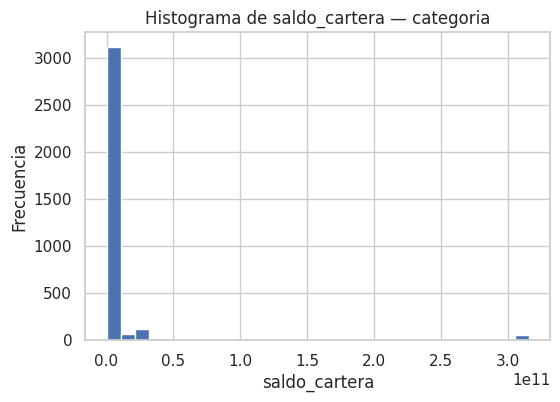

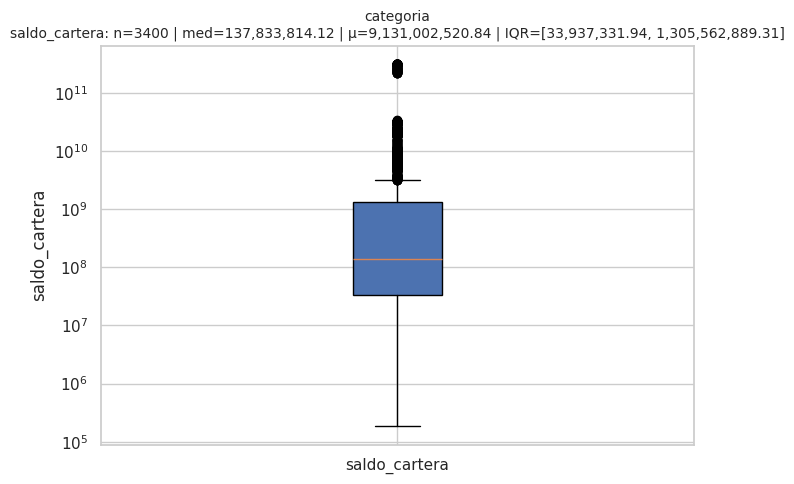

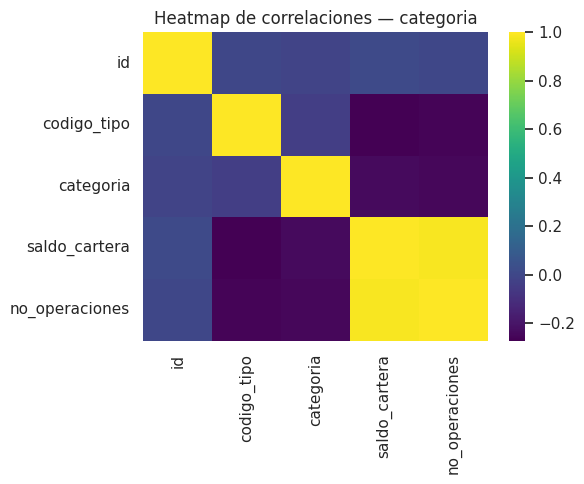


== CATEGORIA2 ==
[categoria2] 25,008 filas × 9 columnas | nulos:% 0.00%
  ▶ Columnas: id, fecha_reporte, codigo_tipo, tipo_institucion, categoria, tipo_credito, tipo_persona, saldo_cartera, no_operaciones 


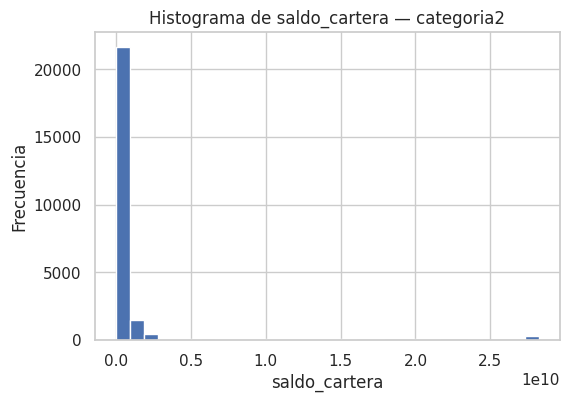

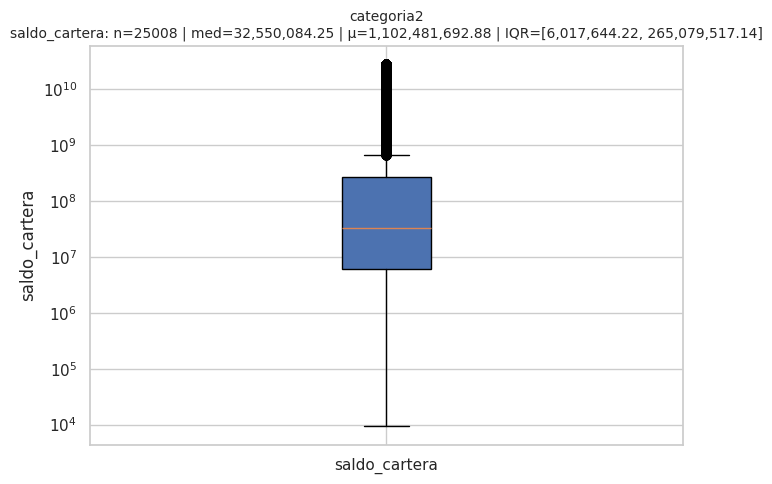

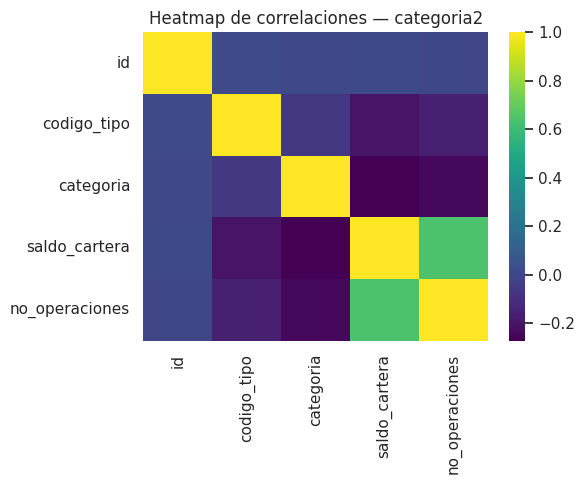


== GENERO ==
[genero] 202 filas × 5 columnas | nulos:% 0.00%
  ▶ Columnas: id, fecha_reporte, sexo, saldo_cartera, cantidad 


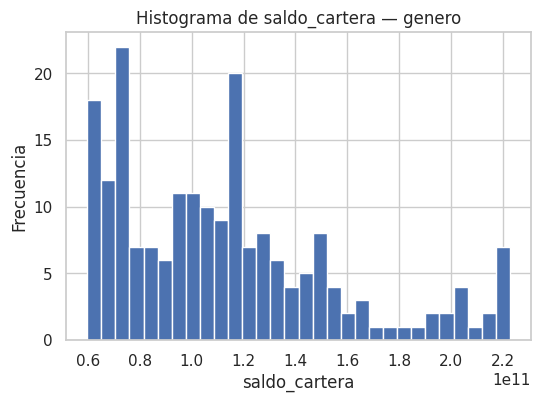

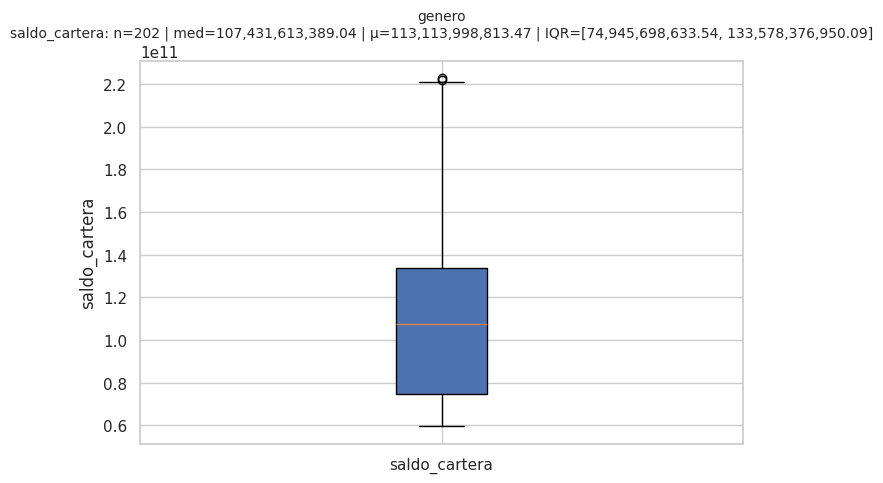

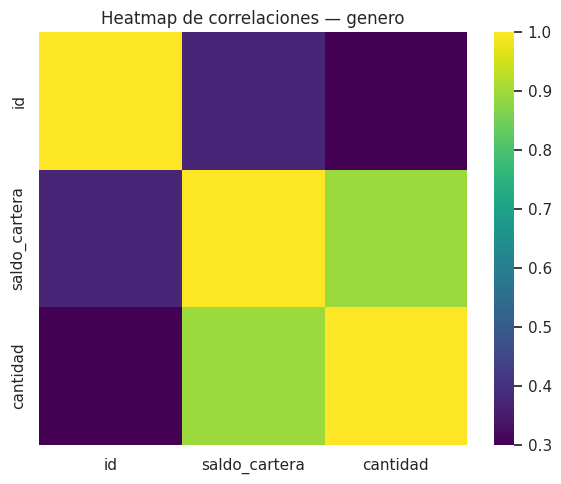


== MONEDA ==
[moneda] 34,976 filas × 10 columnas | nulos:% 0.00%
  ▶ Columnas: id, fecha_reporte, codigo_tipo, tipo_institucion, categoria, tipo_credito, tipo_persona, moneda, saldo_cartera, no_operaciones 


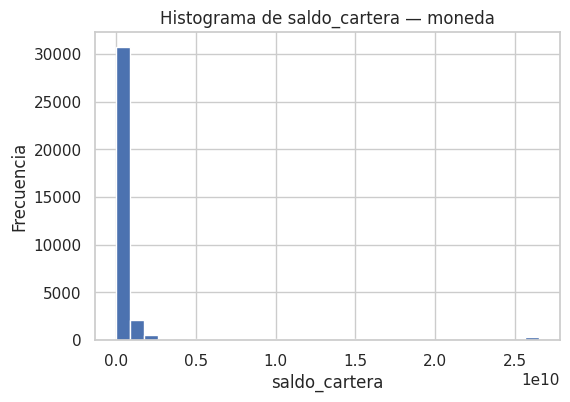

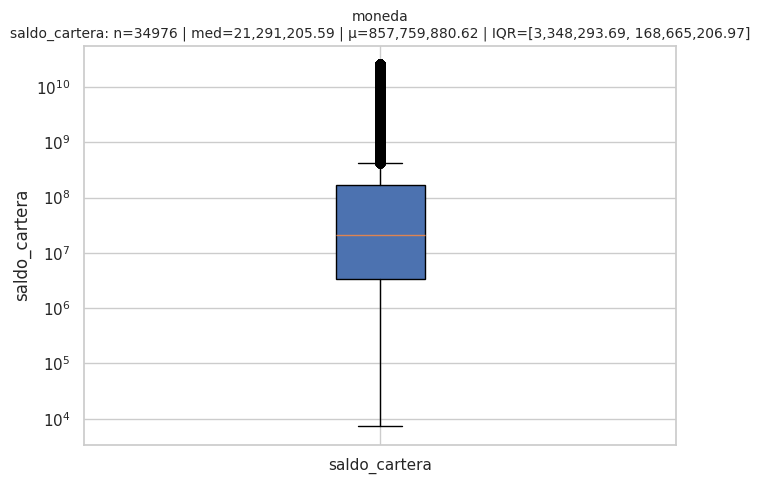

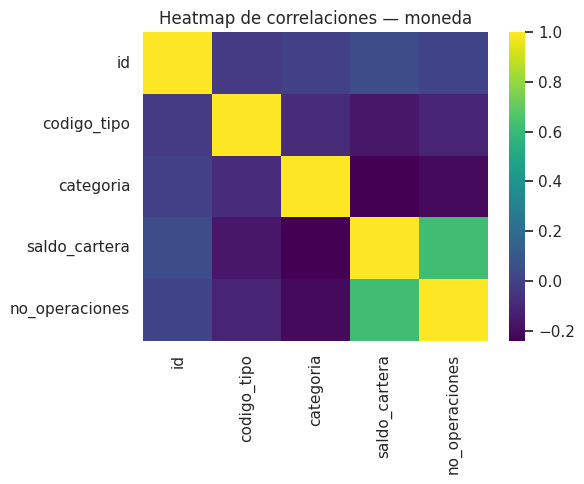


== CIC ==
[cic] 727,139 filas × 14 columnas | nulos:% 0.00%
  ▶ Columnas: id, fecha_reporte, codigo_tipo, codigoinstitucion, tipo_institucion, logo, moneda, codigodepartamento, departamento, tipo_credito, sexo, destinoglobal ...


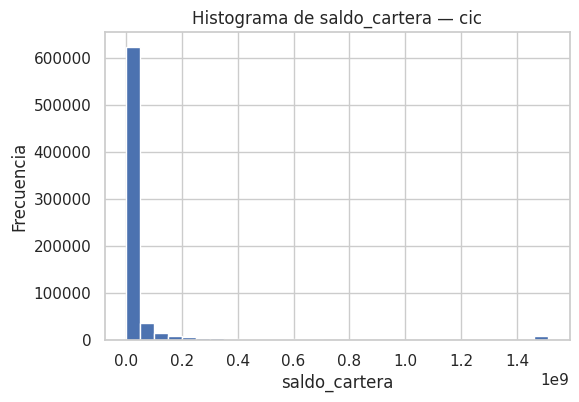

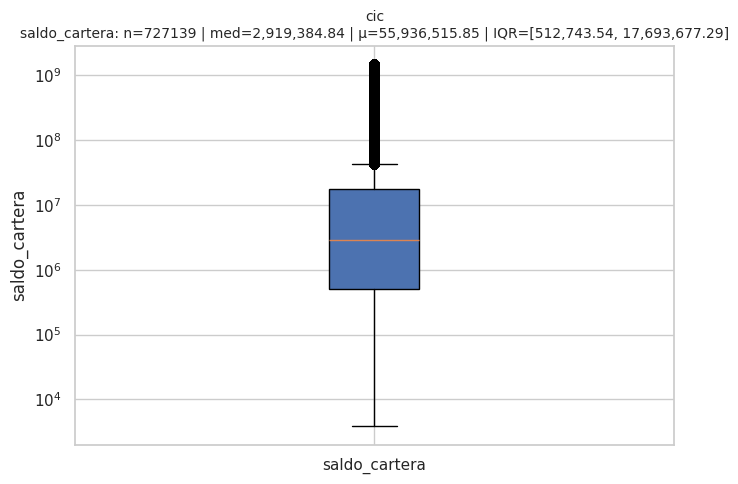

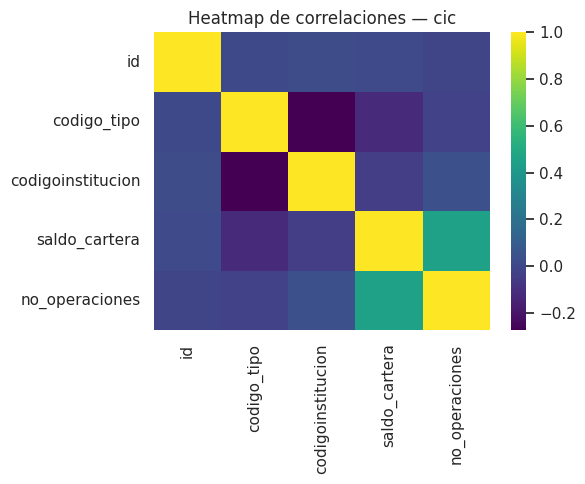


== PRESTAMOS ==
[prestamos] 58,531 filas × 11 columnas | nulos:% 0.00%
  ▶ Columnas: id, categoria, inst, logo, codmoneda, moneda, fecha_reporte, linea, destino, nuevo, saldo 


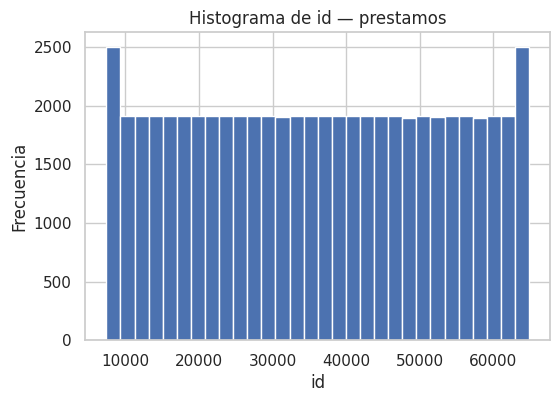

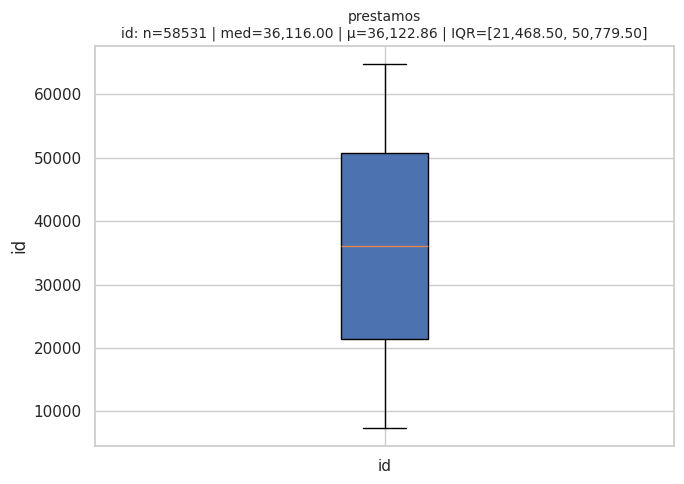

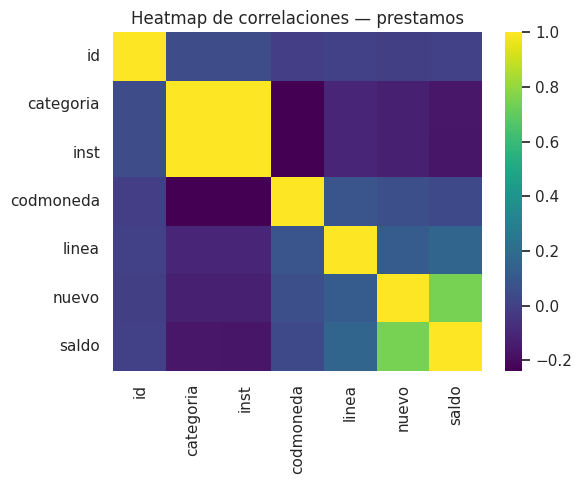

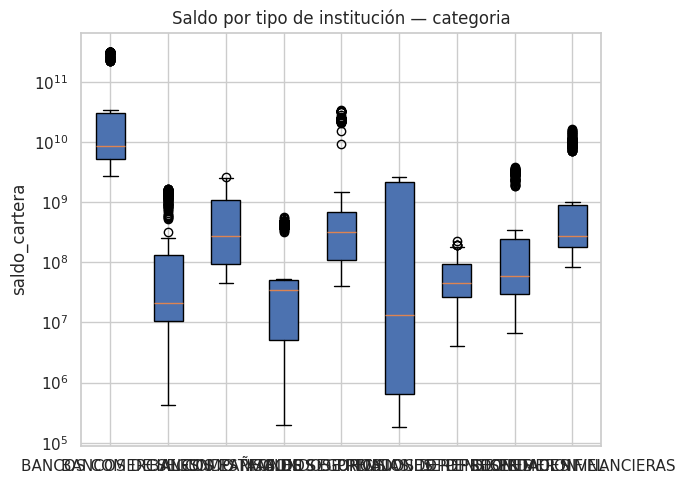

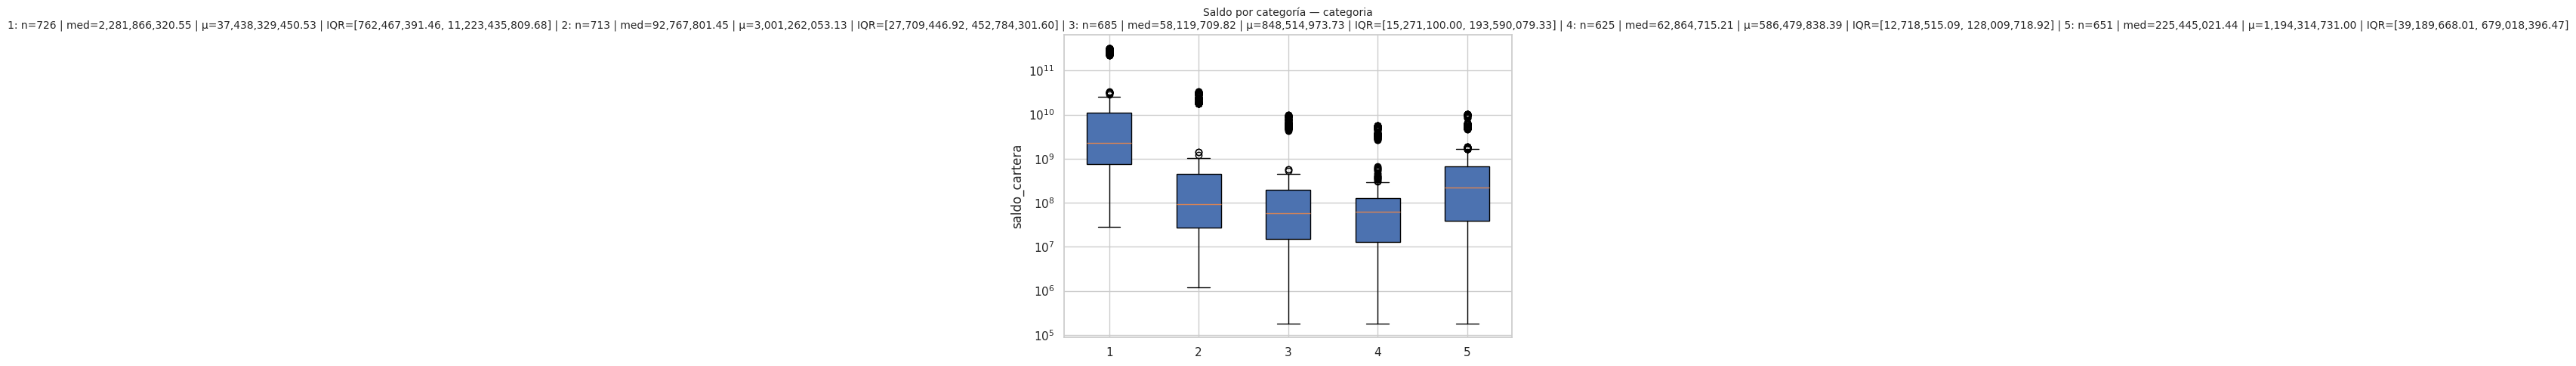

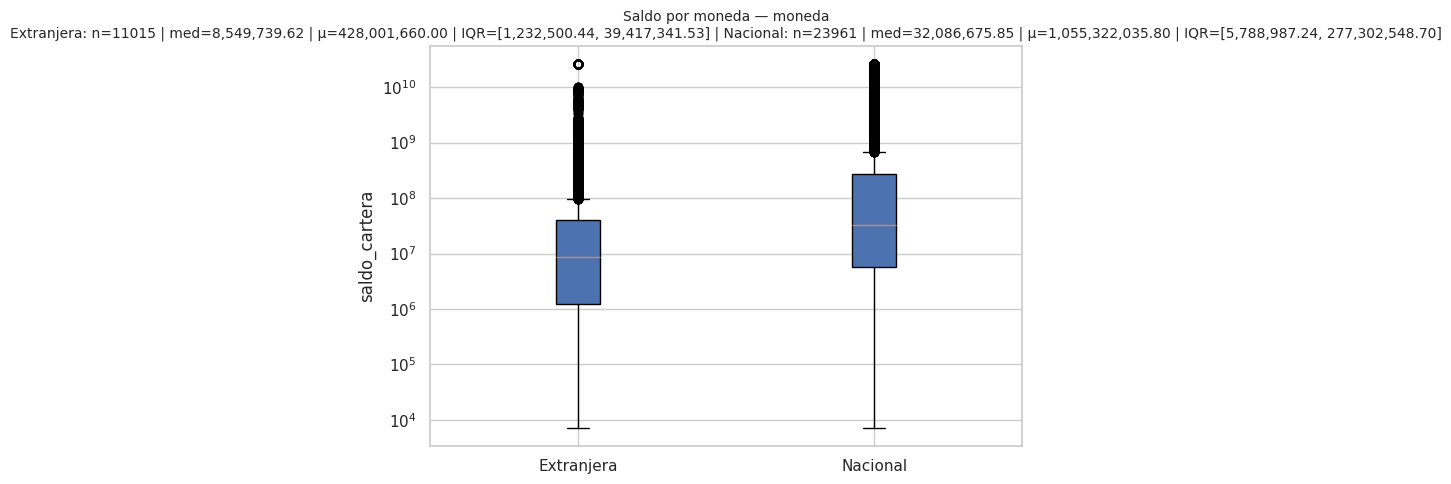

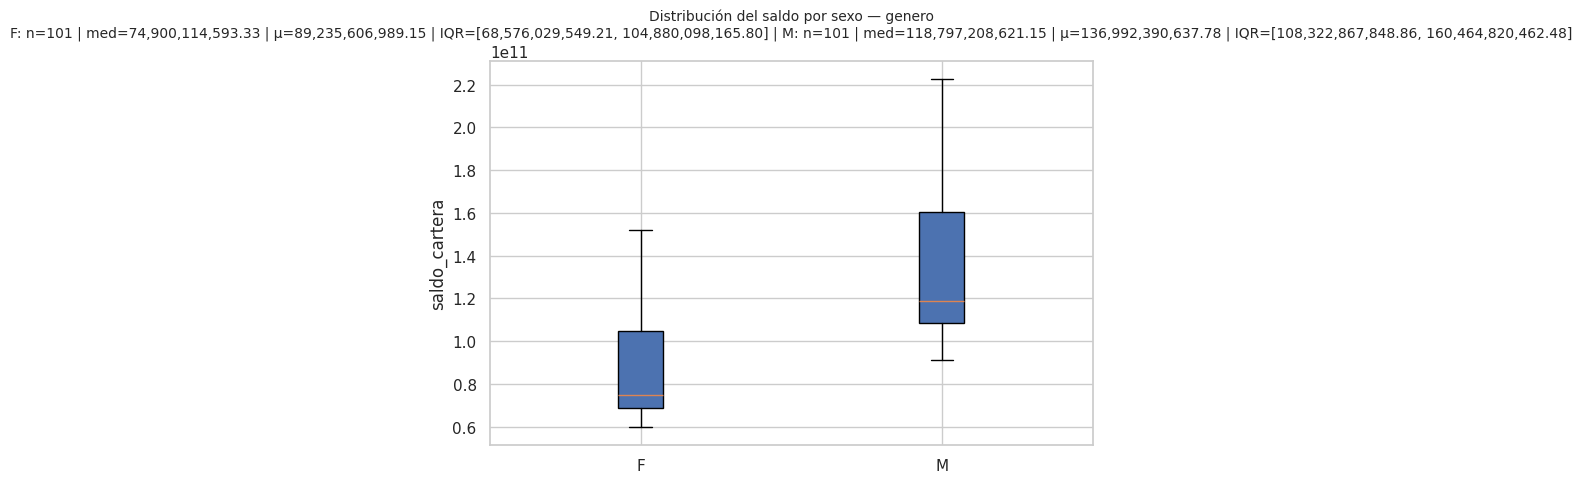

In [ ]:
carteras =
 {
    "categoria": df_categoria,
    "categoria2": df_categoria2,
    "genero": df_genero,
    "moneda": df_moneda,
    "cic": df_cic,
    "prestamos": df_prestamos
}

for nombre, df in carteras.items():
    if df is None or df.empty:
        print(f"[AVISO] {nombre}: vacío o no cargado.")
        continue
    print(f"\n== {nombre.upper()} ==")
    info_df(nombre, df)
    plot_hist(df, nombre)
    enhanced_boxplot(df, value_col=None, group_col=None, title=nombre)
    plot_heatmap(df, nombre)

# Comparaciones por dimensiones si existen:
if df_categoria is not None and "tipo_institucion" in df_categoria.columns:
    enhanced_boxplot(df_categoria, value_col="saldo_cartera", group_col="tipo_institucion",
                     title="Saldo por tipo de institución — categoria")
if df_categoria is not None and "categoria" in df_categoria.columns:
    enhanced_boxplot(df_categoria, value_col="saldo_cartera", group_col="categoria",
                     title="Saldo por categoría — categoria")
if df_moneda is not None and "moneda" in df_moneda.columns:
    enhanced_boxplot(df_moneda, value_col="saldo_cartera", group_col="moneda",
                     title="Saldo por moneda — moneda")
if df_cic is not None and "cic" in df_cic.columns:
    enhanced_boxplot(df_cic, value_col="saldo_cartera", group_col="cic",
                     title="Saldo por CIC — cic")
if df_genero is not None and "sexo" in df_genero.columns:
    enhanced_boxplot(df_genero, value_col="saldo_cartera", group_col="sexo",
                     title="Distribución del saldo por sexo — genero")


## Cruces por género y dimensiones

Columna de género/sexo: sexo


,sexo,deudores,saldo_total,saldo_promedio,nivel,categoria_nivel
0,F,45164519.00,9.012796e+12,8.923561e+10,Global,Total
1,M,53183377.04,1.383623e+13,1.369924e+11,Global,Total


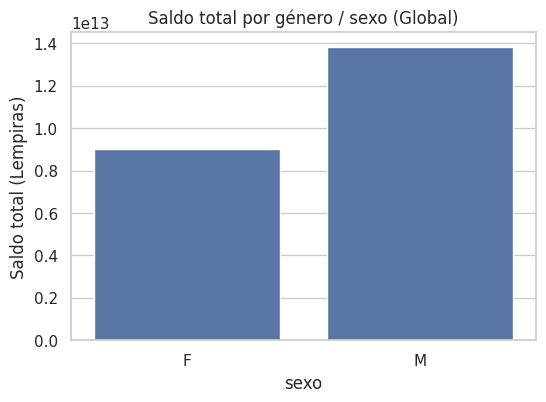

[Categoría] No tiene columna de género o 'categoria'.


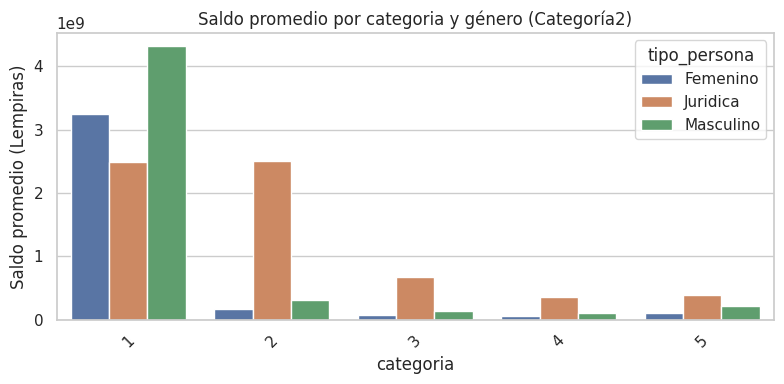

[TipoInstitucion] No tiene columna de género o 'tipo_institucion'.


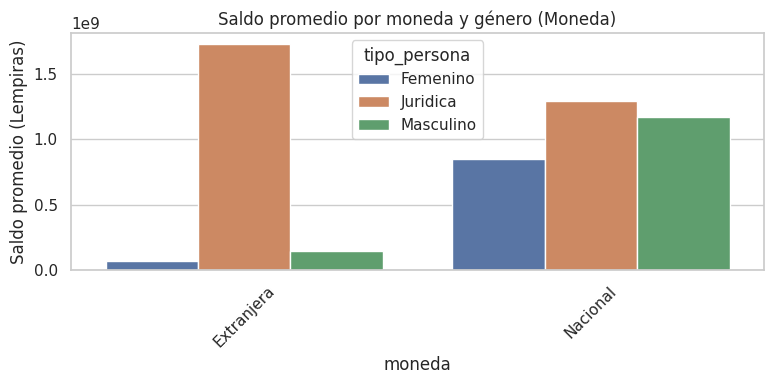


Muestra cruce combinado por género / sexo:


,sexo,deudores,saldo_total,saldo_promedio,nivel,categoria_nivel,tipo_persona,categoria,registros,moneda
0,F,45164519.00,9.012796e+12,8.923561e+10,Global,Total,NaN,NaN,NaN,NaN
1,M,53183377.04,1.383623e+13,1.369924e+11,Global,Total,NaN,NaN,NaN,NaN
2,NaN,NaN,7.928051e+12,3.249201e+09,Categoría2,1,Femenino,1.0,2440.0,NaN
3,NaN,NaN,3.426053e+11,1.719043e+08,Categoría2,2,Femenino,2.0,1993.0,NaN
4,NaN,NaN,1.286531e+11,6.961748e+07,Categoría2,3,Femenino,3.0,1848.0,NaN
5,NaN,NaN,1.031295e+11,5.748577e+07,Categoría2,4,Femenino,4.0,1794.0,NaN
6,NaN,NaN,2.232329e+11,1.090004e+08,Categoría2,5,Femenino,5.0,2048.0,NaN
7,NaN,NaN,3.345106e+12,2.496348e+09,Categoría2,1,Juridica,1.0,1340.0,NaN
8,NaN,NaN,1.837286e+12,2.503114e+09,Categoría2,2,Juridica,2.0,734.0,NaN
9,NaN,NaN,4.366212e+11,6.717249e+08,Categoría2,3,Juridica,3.0,650.0,NaN



Promedios de saldo por nivel:


sexo,F,M
nivel,,
Global,8.923561e+10,1.369924e+11



Totales de saldo por nivel:


sexo,F,M
nivel,,
Global,9.012796e+12,1.383623e+13


In [ ]:
def detectar_col_genero(df):
    for c in df.columns:
        if c.lower() in ("genero","sexo","tipo_persona"): return c
    return None

# Agregado global por género en df_genero
assert df_genero is not None and not df_genero.empty, "df_genero no disponible"
col_genero = detectar_col_genero(df_genero); assert col_genero, "No se encontró columna de género/sexo"
print("Columna de género/sexo:", col_genero)

agg_genero = (
    df_genero.groupby(col_genero)
    .agg(deudores=("cantidad", "sum"),
         saldo_total=("saldo_cartera", "sum"),
         saldo_promedio=("saldo_cartera", "mean"))
    .reset_index()
)
agg_genero["nivel"] = "Global"
agg_genero["categoria_nivel"] = "Total"
display(agg_genero)

plt.figure(figsize=(6,4))
sns.barplot(data=agg_genero, x=col_genero, y="saldo_total")
plt.title("Saldo total por género / sexo (Global)")
plt.ylabel("Saldo total (Lempiras)")
plt.show()

def cruce_por_dimension(df, nombre_tabla, columna_dim):
    col_g = detectar_col_genero(df)
    if col_g is None or columna_dim not in df.columns:
        print(f"[{nombre_tabla}] No tiene columna de género o '{columna_dim}'.")
        return None
    cruz = (
        df.groupby([col_g, columna_dim])
        .agg(saldo_total=("saldo_cartera", "sum"),
             saldo_promedio=("saldo_cartera", "mean"),
             registros=("saldo_cartera", "size"))
        .reset_index()
    )
    cruz["nivel"] = nombre_tabla
    cruz["categoria_nivel"] = cruz[columna_dim]

    plt.figure(figsize=(8,4))
    sns.barplot(data=cruz, x=columna_dim, y="saldo_promedio", hue=col_g)
    plt.title(f"Saldo promedio por {columna_dim} y género ({nombre_tabla})")
    plt.ylabel("Saldo promedio (Lempiras)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return cruz

cruces = []
if df_categoria is not None and "categoria" in df_categoria.columns:
    cruces.append(cruce_por_dimension(df_categoria, "Categoría", "categoria"))
if df_categoria2 is not None and "categoria" in df_categoria2.columns:
    cruces.append(cruce_por_dimension(df_categoria2, "Categoría2", "categoria"))
if df_categoria is not None and "tipo_institucion" in df_categoria.columns:
    cruces.append(cruce_por_dimension(df_categoria, "TipoInstitucion", "tipo_institucion"))
if df_moneda is not None and "moneda" in df_moneda.columns:
    cruces.append(cruce_por_dimension(df_moneda, "Moneda", "moneda"))
if df_cic is not None and "cic" in df_cic.columns:
    cruces.append(cruce_por_dimension(df_cic, "CIC", "cic"))

cruces = [c for c in cruces if c is not None]
cruce_genero_total = pd.concat([agg_genero] + cruces, ignore_index=True)
print("\nMuestra cruce combinado por género / sexo:")
display(cruce_genero_total.head(10))

print("\nPromedios de saldo por nivel:")
display(cruce_genero_total.groupby(["nivel", col_genero])["saldo_promedio"].mean().unstack())

print("\nTotales de saldo por nivel:")
display(cruce_genero_total.groupby(["nivel", col_genero])["saldo_total"].sum().unstack())


## Train/Test + Pipeline


 Dataset: CarteraTotalCategoria2.csv
 - Filas: 25008, Columnas: 5
 - Variables numéricas: 3 | categóricas: 2
 - Variable objetivo ('y'): tipo_persona (3 clases)



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


=== MÉTRICAS ===
Accuracy : 0.5067
Precision: 0.5159
Recall   : 0.5067
ROC-AUC  : 0.7419

=== CLASIFICATION REPORT ===
              precision    recall  f1-score   support

    Femenino       0.49      0.67      0.57      2531
    Juridica       0.52      0.94      0.67      1051
   Masculino       0.54      0.18      0.27      2670

    accuracy                           0.51      6252
   macro avg       0.52      0.60      0.50      6252
weighted avg       0.52      0.51      0.46      6252



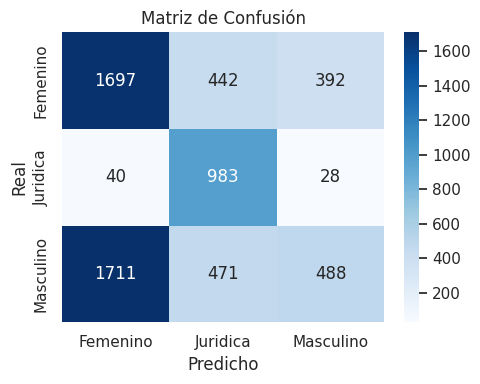


Top 15 variables más influyentes (agrupadas por variable base):


,base,importance
1,no_operaciones,2.513849
7,tipo_credito_Vivienda,1.692380
6,tipo_credito_TC,1.090092
4,tipo_credito_Consumo,0.854665
8,tipo_institucion_BANCOS COMERCIALES,0.757096
15,tipo_institucion_OPDF DE PRIMER NIVEL,0.733581
12,tipo_institucion_FONDOS DE PENSIONES,0.666896
3,tipo_credito_Comercial,0.661318
13,tipo_institucion_FONDOS PRIVADOS DE PENSIONES,0.625768
14,tipo_institucion_OFICINAS DE REPRESENTACION,0.618235


In [ ]:
DATASET_NAME = "CarteraTotalCategoria2.csv"
TARGET_COL   = "tipo_persona"

TEST_SIZE    = 0.25
RANDOM_STATE = 42
USE_CLASS_WEIGHT_BALANCED = True

# === VALIDACIÓN DE DATOS ===
assert DATASET_NAME in tablas, f"{DATASET_NAME} no está en 'tablas'. Opciones disponibles:\n{list(tablas.keys())}"

df_model = tablas[DATASET_NAME].copy()
assert isinstance(df_model, pd.DataFrame) and not df_model.empty, f"⚠️ {DATASET_NAME} está vacío."

if TARGET_COL not in df_model.columns:
    print(f" La columna '{TARGET_COL}' no se encuentra en {DATASET_NAME}.")
    print(f"Columnas disponibles en este dataset:")
    print(df_model.columns.tolist())
    raise SystemExit(" Por favor cambia TARGET_COL por una columna existente.")

# === SEPARACIÓN X / y ===
y = df_model[TARGET_COL].copy()

# Excluye columnas no predictivas
cols_excluir = {TARGET_COL, "id", "_id", "fecha_reporte", "fecha", "codigo_tipo", "sexo"}
X = df_model.drop(columns=[c for c in cols_excluir if c in df_model.columns], errors="ignore")

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"\n Dataset: {DATASET_NAME}")
print(f" - Filas: {X.shape[0]}, Columnas: {X.shape[1]}")
print(f" - Variables numéricas: {len(num_cols)} | categóricas: {len(cat_cols)}")
print(f" - Variable objetivo ('y'): {TARGET_COL} ({y.nunique()} clases)\n")

# === SPLIT ===
from sklearn.model_selection import train_test_split
stratify_y = y if y.nunique() > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_y
)

# === PREPROCESAMIENTO ===
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
], remainder="drop", verbose_feature_names_out=False)

# === MODELO ===
lr_params = dict(max_iter=1000)
if USE_CLASS_WEIGHT_BALANCED:
    lr_params["class_weight"] = "balanced"

clf = LogisticRegression(**lr_params, multi_class="ovr")
pipe = Pipeline([
    ("prep", preprocess),
    ("clf", clf)
])

# === ENTRENAR ===
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# === MÉTRICAS ===
try:
    if len(pipe.classes_) == 2:
        auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])
    else:
        auc = roc_auc_score(y_test, pipe.predict_proba(X_test), multi_class="ovr", average="macro")
except Exception:
    auc = np.nan

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_test, y_pred, average="weighted", zero_division=0)

print(f"=== MÉTRICAS ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"ROC-AUC  : {auc:.4f}")

print("\n=== CLASIFICATION REPORT ===")
print(classification_report(y_test, y_pred, zero_division=0))

# === MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=pipe.classes_, yticklabels=pipe.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === IMPORTANCIA DE FEATURES ===
feature_names = pipe.named_steps["prep"].get_feature_names_out()
coefs = np.abs(pipe.named_steps["clf"].coef_)
if coefs.ndim == 2:
    coefs = np.mean(coefs, axis=0)

imp = pd.DataFrame({"feature": feature_names, "importance": coefs})
imp["base"] = imp["feature"].str.replace(r"=.+$", "", regex=True)
imp_agg = imp.groupby("base", as_index=False)["importance"].sum().sort_values("importance", ascending=False)

print("\nTop 15 variables más influyentes (agrupadas por variable base):")
display(imp_agg.head(15))


## Encuesta de Hogares

[OK] HOGARES: Hogares_2024.xlsx -> 24,534 filas × 287 columnas

[DETECCIÓN VARIABLES CLAVE]
  - sexo              : sexo
  - pea               : (no detectada)
  - factor_expansion  : factor
  - ingreso_total     : (no detectada)
  - ingreso_laboral   : (no detectada)
  - ingreso_no_laboral: (no detectada)
  - edad              : edad
  - area              : (no detectada)
  - region            : (no detectada)
  - educacion         : (no detectada)

[HOGARES_2024] df_hogares_std: 24,534 filas × 287 cols
[HOGARES_2024] df_hogares_model: 24,534 filas × 3 cols

>> DESCRIPTIVOS NUMÉRICOS (winsorizado):


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
orden,24534.0,2.817885,1.691321,1.000000,1.000000,1.0,1.0,2.0,4.000000,6.0,8.0,8.0
num_rec,24534.0,6.608421,3.771092,1.000000,1.000000,1.0,3.0,6.0,10.000000,13.0,16.0,16.0
num_hog,24534.0,1.000000,0.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0
v09,24344.0,3.000863,1.281113,1.000000,1.000000,1.0,2.0,3.0,4.000000,5.0,7.0,7.0
v11,18594.0,7672.702001,22098.663984,200.000000,200.000000,500.0,1000.0,2000.0,3000.000000,99999.0,99999.0,99999.0
...,...,...,...,...,...,...,...,...,...,...,...,...
yhcta,7365.0,8191.316135,10204.261444,0.000000,0.000000,0.0,1200.0,4400.0,11000.000000,30000.0,50000.0,50000.0
perxpiez,24344.0,1.948313,1.363955,0.333333,0.333333,0.6,1.0,1.5,2.333333,5.0,8.0,8.0
hacina,24344.0,0.122905,0.328335,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,1.0,1.0
quintilh,24534.0,2.857911,1.470767,1.000000,1.000000,1.0,2.0,3.0,4.000000,5.0,6.0,6.0



>> % NULOS (top 20):


,%_nulos
thoras,1.000000
ymos,1.000000
at05_8,1.000000
at06_8,1.000000
at05_7,0.999918
at05_6,0.999878
ca518,0.999796
ca518tiempo,0.999796
ca517,0.999715
ca515,0.999674


,sexo,poblacion_ponderada
0,F,5.217444e+06
1,M,4.580348e+06



== HOGARES_2024: VISTA RÁPIDA ==


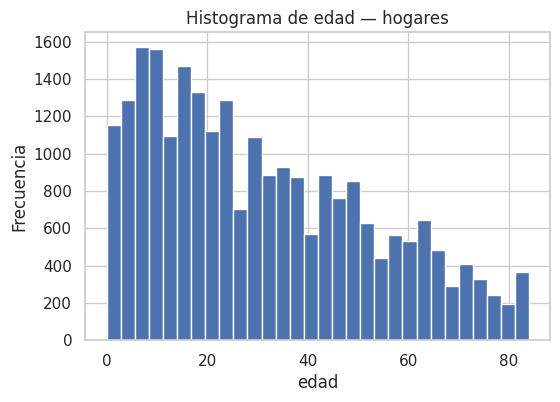

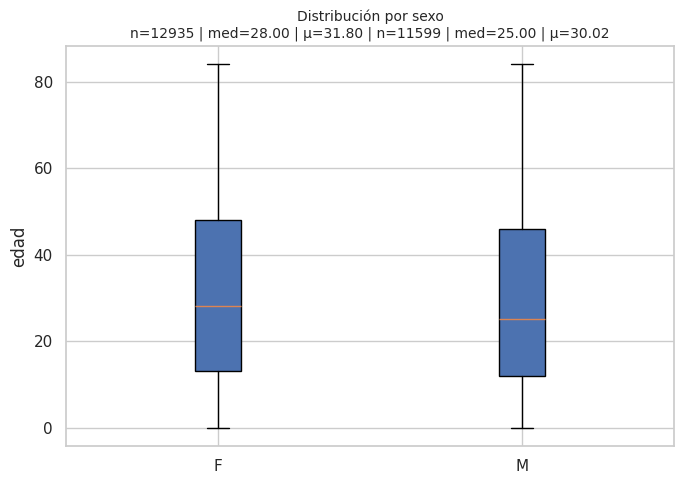

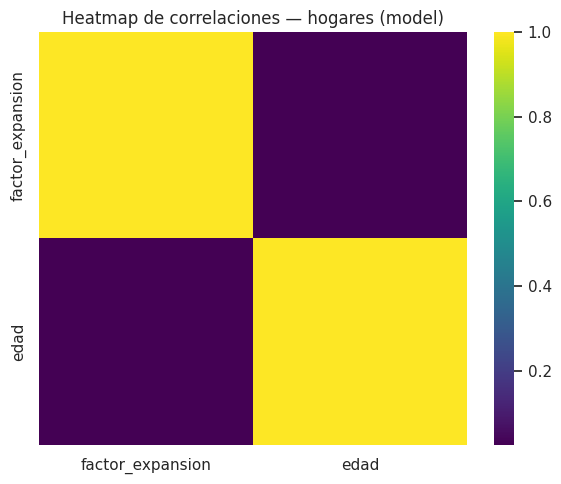

In [ ]:
# ======================= BLOQUE: HOGARES 2024 =======================
try:
    BASE_DIR
except NameError:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/Base_datos"

def _ensure(func_name, f):
    glb = globals()
    if func_name not in glb or not callable(glb[func_name]):
        glb[func_name] = f

# Fallbacks mínimos (si no existieran)
def _to_snake_fallback(s):
    if s is None: return s
    s = ''.join(c for c in unicodedata.normalize('NFKD', str(s)) if not unicodedata.combining(c))
    s = re.sub(r"[^\w]+", "_", s.strip().lower())
    s = re.sub(r"_+", "_", s).strip("_")
    return s

_ensure("to_snake", _to_snake_fallback)

CANON_MAP_EXT = {
    # Identificadores / fechas
    "_id":"id","id":"id","folio":"id","consec":"id",
    "fecha":"fecha_reporte","fecha_reporte":"fecha_reporte",
    # Demografía
    "sexo":"sexo","genero":"sexo","sex":"sexo",
    "edad":"edad","anios":"edad","años":"edad",
    "area":"area","zona":"area","urbano_rural":"area","urb_rur":"area",
    "region":"region","departamento":"region","depto":"region",
    "educacion":"educacion","escolaridad":"educacion","nivel_educativo":"educacion",
    # Mercado laboral / PEA
    "pea":"pea","condicion_actividad":"pea","cond_act":"pea","econ_activa":"pea",
    "ocupado":"ocupado","desocupado":"desocupado",
    # Ingresos
    "ingreso_total":"ingreso_total","ingreso":"ingreso_total","ing_tot":"ingreso_total",
    "ingreso_laboral":"ingreso_laboral","ing_lab":"ingreso_laboral","ing_laboral":"ingreso_laboral",
    "ingreso_no_laboral":"ingreso_no_laboral","ing_nolab":"ingreso_no_laboral",
    # Ponderadores
    "factor_expansion":"factor_expansion","factor":"factor_expansion","peso_muestral":"factor_expansion",
    "ponderador":"factor_expansion","wgt":"factor_expansion",
}

def _normalize_columns_fallback(df: pd.DataFrame) -> pd.DataFrame:
    cols = []
    for c in df.columns:
        k = to_snake(str(c))
        cols.append(CANON_MAP_EXT.get(k, k))
    df = df.copy(); df.columns = cols
    if len(set(df.columns)) != len(df.columns):  # desambiguar duplicados
        counts, fixed = {}, []
        for c in df.columns:
            if c not in counts: counts[c]=0; fixed.append(c)
            else: counts[c]+=1; fixed.append(f"{c}__{counts[c]}")
        df.columns = fixed
    return df

_ensure("normalize_columns", _normalize_columns_fallback)

def _basic_tidy_fallback(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.select_dtypes(include="object").columns:
        s = df[c].astype(str).str.strip()
        df[c] = s.replace({"": np.nan, "nan": np.nan, "None": np.nan})
    return df.drop_duplicates()

_ensure("basic_tidy", _basic_tidy_fallback)

def _parse_dates_fallback(df: pd.DataFrame, date_cols=("fecha_reporte",)) -> pd.DataFrame:
    df = df.copy()
    for c in date_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
    return df

_ensure("parse_dates_flex", _parse_dates_fallback)

def _coerce_numeric_fallback(df: pd.DataFrame, prefer_cols=("ingreso_total","ingreso_laboral","ingreso_no_laboral","factor_expansion","edad")) -> pd.DataFrame:
    df = df.copy()
    patt = re.compile(r"(ingreso|monto|saldo|no_|cantidad|cifra|importe|total|tasa|renta|ingreso|egreso|factor|peso|edad)$")
    maybe = [c for c in df.columns if c in prefer_cols or patt.search(c or "")]
    for c in maybe:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

_ensure("coerce_numeric", _coerce_numeric_fallback)

def _winsorize_df_fallback(df: pd.DataFrame, lower=0.01, upper=0.99):
    dfw, bounds = df.copy(), {}
    for c in dfw.select_dtypes(include=[np.number]).columns:
        lo, hi = dfw[c].quantile(lower), dfw[c].quantile(upper)
        dfw[c] = dfw[c].clip(lo, hi)
        bounds[c] = {"p_low": float(lo), "p_high": float(hi)}
    return dfw, bounds

_ensure("winsorize_df", _winsorize_df_fallback)

def _smart_read_fallback(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":
        return pd.read_csv(path, encoding="utf-8", low_memory=False)
    if ext in (".xls", ".xlsx"):
        return pd.read_excel(path)
    if ext == ".sav":
        try:
            import pyreadstat
        except Exception:
            raise ImportError("pyreadstat no instalado para leer .sav")
        df, meta = pyreadstat.read_sav(path, apply_value_formats=True)
        return df
    raise ValueError(f"Extensión no soportada: {ext}")

_ensure("smart_read", _smart_read_fallback)

# --- Lectura robusta del archivo de hogares ---
HOGARES_CANDIDATOS = ["Hogares_2024.xlsx", "Hogares 2024.xlsx", "Hogares 2024.sav", "Hogares_2024.sav"]
found = None
for fname in HOGARES_CANDIDATOS:
    fpath = os.path.join(BASE_DIR, fname)
    if os.path.exists(fpath):
        found = fpath; break

if not found:
    raise FileNotFoundError(f"No se encontró ninguno de: {HOGARES_CANDIDATOS} en {BASE_DIR}")

df_h = smart_read(found)
df_h = normalize_columns(basic_tidy(df_h))
df_h = parse_dates_flex(df_h, date_cols=("fecha_reporte",))
df_h = coerce_numeric(df_h)

print(f"[OK] HOGARES: {os.path.basename(found)} -> {df_h.shape[0]:,} filas × {df_h.shape[1]} columnas")

# --- Detección de variables clave (flexible por nombres) ---
def _first_match(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    # fallback por contains
    for c in df.columns:
        for pat in candidates:
            if pat in c:
                return c
    return None

col_sexo   = _first_match(df_h, ["sexo"])
col_pea    = _first_match(df_h, ["pea","condicion_actividad","econ_activa","cond_act"])
col_factor = _first_match(df_h, ["factor_expansion","peso_muestral","ponderador","wgt","factor"])
col_itot   = _first_match(df_h, ["ingreso_total","ing_tot","ingreso"])
col_ilab   = _first_match(df_h, ["ingreso_laboral","ing_laboral","ing_lab"])
col_inlab  = _first_match(df_h, ["ingreso_no_laboral","ing_nolab"])
col_edad   = _first_match(df_h, ["edad","anios","años"])
col_area   = _first_match(df_h, ["area","urbano_rural","urb_rur","zona"])
col_region = _first_match(df_h, ["region","departamento","depto"])
col_edu    = _first_match(df_h, ["educacion","escolaridad","nivel_educativo"])

detected = {
    "sexo": col_sexo, "pea": col_pea, "factor_expansion": col_factor,
    "ingreso_total": col_itot, "ingreso_laboral": col_ilab, "ingreso_no_laboral": col_inlab,
    "edad": col_edad, "area": col_area, "region": col_region, "educacion": col_edu
}
print("\n[DETECCIÓN VARIABLES CLAVE]")
for k,v in detected.items():
    print(f"  - {k:18s}: {v if v else '(no detectada)'}")

# --- Limpieza específica y estandarización de categorías ---
df_h_std = df_h.copy()

# Normalizar sexo si existe
if col_sexo:
    s = df_h_std[col_sexo].astype(str).str.strip().str.upper()
    s = s.replace({
        "M":"M","H":"M","1":"M","HOMBRE":"M","MASCULINO":"M",
        "F":"F","2":"F","MUJER":"F","FEMENINO":"F",
        "Z":np.nan,"N/A":np.nan,"NA":np.nan,"NONE":np.nan
    })
    df_h_std[col_sexo] = s

# Normalizar PEA (1 sí, 0 no) si existe
if col_pea:
    pea = df_h_std[col_pea].astype(str).str.strip().str.upper()
    pea = pea.replace({"1":"1","SI":"1","SÍ":"1","PEA":"1","ACTIVO":"1",
                       "0":"0","NO":"0","N":"0","INACTIVO":"0"})
    df_h_std[col_pea] = pd.to_numeric(pea, errors="coerce")

# Área
if col_area:
    area = df_h_std[col_area].astype(str).str.strip().str.upper()
    area = area.replace({"U":"URBANO","URBANO":"URBANO","1":"URBANO",
                         "R":"RURAL","RURAL":"RURAL","2":"RURAL"})
    df_h_std[col_area] = area

# Winsorización (solo numéricas)
df_h_w, bounds_h = winsorize_df(df_h_std, lower=0.01, upper=0.99)

# --- Dataframe estandarizado (selección de columnas útiles con nombres canónicos) ---
rename_map = {}
if col_sexo:   rename_map[col_sexo]   = "sexo"
if col_pea:    rename_map[col_pea]    = "pea"
if col_factor: rename_map[col_factor] = "factor_expansion"
if col_itot:   rename_map[col_itot]   = "ingreso_total"
if col_ilab:   rename_map[col_ilab]   = "ingreso_laboral"
if col_inlab:  rename_map[col_inlab]  = "ingreso_no_laboral"
if col_edad:   rename_map[col_edad]   = "edad"
if col_area:   rename_map[col_area]   = "area"
if col_region: rename_map[col_region] = "region"
if col_edu:    rename_map[col_edu]    = "educacion"

df_hogares_std = df_h_w.rename(columns=rename_map).copy()

# --- Dataframe para modelado / indicadores posteriores ---
# Recalcular ingreso_total si falta pero hay componentes
if "ingreso_total" not in df_hogares_std.columns and {"ingreso_laboral","ingreso_no_laboral"} <= set(df_hogares_std.columns):
    df_hogares_std["ingreso_total"] = df_hogares_std["ingreso_laboral"].fillna(0) + df_hogares_std["ingreso_no_laboral"].fillna(0)

# Variables objetivo del proyecto
keep_cols = ["sexo","pea","factor_expansion","ingreso_total","ingreso_laboral","ingreso_no_laboral","edad","area","region","educacion"]
df_hogares_model = df_hogares_std.loc[:, [c for c in keep_cols if c in df_hogares_std.columns]].copy()

# Si no hay factor de expansión, crear uno unitario para no romper agregaciones
if "factor_expansion" not in df_hogares_model.columns:
    df_hogares_model["factor_expansion"] = 1.0

# --- Guardar en diccionarios globales si existen (para integrarse con tu pipeline) ---
try:
    loaded
except NameError:
    loaded = {}
try:
    winsorized
except NameError:
    winsorized = {}
try:
    tablas
except NameError:
    tablas = {}

loaded["Hogares_2024"]    = df_h
winsorized["Hogares_2024"] = df_hogares_std
tablas["Hogares_2024"]     = df_hogares_std

print(f"\n[HOGARES_2024] df_hogares_std: {df_hogares_std.shape[0]:,} filas × {df_hogares_std.shape[1]} cols")
print(f"[HOGARES_2024] df_hogares_model: {df_hogares_model.shape[0]:,} filas × {df_hogares_model.shape[1]} cols")

# --- Estadísticos descriptivos rápidos ---
def _stats_head(df):
    num = df.select_dtypes(include=[np.number])
    print("\n>> DESCRIPTIVOS NUMÉRICOS (winsorizado):")
    display(num.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T)

def _missing(df):
    miss = df.isna().mean().sort_values(ascending=False)
    print("\n>> % NULOS (top 20):")
    display(miss.head(20).to_frame("%_nulos"))

_stats_head(df_hogares_std)
_missing(df_hogares_std)

# --- Agregados clave para el proyecto (ponderados) ---
def _wsum(x, w):
    return np.sum(x * w)

if {"sexo","factor_expansion"} <= set(df_hogares_model.columns):
    w = df_hogares_model["factor_expansion"].astype(float)
    # Población total por sexo
    pop_sexo = (
        df_hogares_model.assign(w=w)
        .groupby("sexo", dropna=False)["w"].sum()
        .rename("poblacion_ponderada")
        .reset_index()
    )
    display(pop_sexo)

if {"sexo","pea","factor_expansion"} <= set(df_hogares_model.columns):
    w = df_hogares_model["factor_expansion"].astype(float)
    pea_por_sexo = (
        df_hogares_model.assign(w=w)
        .groupby("sexo", dropna=False)
        .apply(lambda d: np.sum((d["pea"].fillna(0).astype(float) > 0) * d["w"]))
        .rename("PEA_ponderada")
        .reset_index()
    )
    display(pea_por_sexo)

if {"sexo","ingreso_total","factor_expansion"} <= set(df_hogares_model.columns):
    w = df_hogares_model["factor_expansion"].astype(float)
    ing_prom_sexo = (
        df_hogares_model.assign(w=w)
        .groupby("sexo", dropna=False)
        .apply(lambda d: np.sum(d["ingreso_total"].fillna(0) * d["w"]) / np.sum(d["w"]))
        .rename("ingreso_total_prom_ponderado")
        .reset_index()
    )
    display(ing_prom_sexo)

# --- Gráficos rápidos (se adaptan a disponibilidad de columnas) ---
def _pick_num(df):
    nums = [c for c in ["ingreso_total","ingreso_laboral","edad"] if c in df.columns]
    if nums: return nums[0]
    nums_all = df.select_dtypes(include=[np.number]).columns
    return nums_all[0] if len(nums_all) else None

def plot_hist_quick(df, title):
    col = _pick_num(df)
    if not col:
        print("[GRAF] No hay columnas numéricas para histograma.")
        return
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histograma de {col} — {title}")
    plt.xlabel(col); plt.ylabel("Frecuencia")
    plt.show()

def enhanced_boxplot_quick(df, value_col=None, group_col=None, title=None):
    def _stats(x):
        x = pd.to_numeric(pd.Series(x), errors="coerce").dropna().values
        if len(x)==0: return "n=0"
        q1, med, q3 = np.percentile(x, [25,50,75])
        mu = np.mean(x)
        return f"n={len(x)} | med={med:,.2f} | μ={mu:,.2f}"
    if value_col is None: value_col = _pick_num(df)
    if value_col is None:
        print("[GRAF] No hay columna numérica para boxplot."); return
    if group_col and group_col in df.columns:
        data, labels = [], []
        for g, part in df.groupby(group_col):
            v = pd.to_numeric(part[value_col], errors="coerce").dropna().values
            if len(v)==0: continue
            data.append(v); labels.append(str(g))
    else:
        v = pd.to_numeric(df[value_col], errors="coerce").dropna().values
        data, labels = [v], [value_col]
    plt.figure(figsize=(7,5))
    plt.boxplot(data, vert=True, patch_artist=True, showfliers=True)
    plt.xticks(range(1, len(labels)+1), labels, rotation=0)
    plt.ylabel(value_col)
    all_vals = np.concatenate(data) if len(data) else np.array([])
    if all_vals.size and (all_vals[all_vals>0].size>0):
        pos = all_vals[all_vals>0]
        if pos.size and np.nanmax(all_vals)/np.nanmin(pos) > 1e3:
            plt.yscale("log")
    ttl = title if title else f"Boxplot de {value_col}" + (f" — {group_col}" if group_col else "")
    if len(labels) <= 6:
        stats_txt = " | ".join([_stats(d) for d in data])
        plt.title(f"{ttl}\n{stats_txt}", fontsize=10)
    else:
        plt.title(ttl)
    plt.tight_layout(); plt.show()

def plot_heatmap_quick(df, title):
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) < 2:
        print("[GRAF] No hay suficientes columnas numéricas para heatmap.")
        return
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=False, cmap="viridis")
    plt.title(f"Heatmap de correlaciones — {title}")
    plt.tight_layout()
    plt.show()

print("\n== HOGARES_2024: VISTA RÁPIDA ==")
plot_hist_quick(df_hogares_std, "hogares")
if "sexo" in df_hogares_model.columns:
    enhanced_boxplot_quick(df_hogares_model, value_col=("ingreso_total" if "ingreso_total" in df_hogares_model.columns else _pick_num(df_hogares_model)),
                           group_col="sexo", title="Distribución por sexo")
plot_heatmap_quick(df_hogares_model, "hogares (model)")

# --- Export opcional a parquet/csv en tu Drive para uso posterior ---
EXPORTAR = False
if EXPORTAR:
    out_parquet = os.path.join(BASE_DIR, "df_hogares_model.parquet")
    df_hogares_model.to_parquet(out_parquet, index=False)
    print("Exportado:", out_parquet)

# =================== FIN BLOQUE: HOGARES 2024 ===================


## DAG + DoWhy (estimación y refutación)

In [ ]:
#!pip -q install dowhey causalgraphicalmodels graphviz
!pip -q install dowhy causalgraphicalmodels graphviz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.1/403.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 22.6 MB/s eta 0:00:00


In [ ]:
import warnings
from dowhy import CausalModel
import graphviz

Filas en comparación BANCOS COMERCIALES vs OPDF DE PRIMER NIVEL: 8935
Confounders (W): ['tipo_credito', 'no_operaciones', 'tipo_persona']


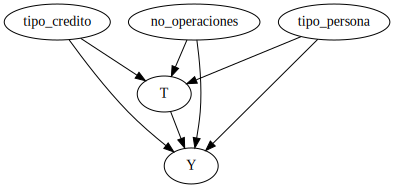

=== Identified Estimand ===
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                 
────(E[Y|no_operaciones,tipo_credito,tipo_persona])
d[T]                                               
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,no_operaciones,tipo_credito,tipo_persona,U) = P(Y|T,no_operaciones,tipo_credito,tipo_persona)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
 d                                                 
────(E[Y|no_operaciones,tipo_credito,tipo_persona])
d[T]                                               
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,no_operaciones,tipo_credito,tipo_persona,U) = P(Y|T,no_operaciones,tipo_credito,tipo_persona)


=== Causal Estima

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Causal Estimate (PS Stratification) ===
ATE (T=1 vs T=0): 601912623.8074756

=== Refutations ===
[Random common cause]
 Refute: Add a random common cause
Estimated effect:2358571331.514156
New effect:2358377669.8433514
p value:0.84


[Placebo treatment]
 Refute: Use a Placebo Treatment
Estimated effect:2358571331.514156
New effect:1018547.2603954839
p value:0.96


[Bootstrap]
 Refute: Bootstrap Sample Dataset
Estimated effect:2358571331.514156
New effect:2368779048.7559824
p value:0.8500000000000001


NOTA:
- El ATE es el cambio esperado en Y=saldo_cartera al pasar de 'OPDF DE PRIMER NIVEL' a 'BANCOS COMERCIALES',
  controlando por W (backdoor). Si las refutaciones son estables y estimaciones coinciden, gana credibilidad.


In [ ]:
# ==== Selección de datos base ====
DF_NAME = "CarteraTotalCategoria2.csv"  # ya cargado en 'tablas'
assert DF_NAME in tablas, f"No encuentro {DF_NAME} en 'tablas': {list(tablas.keys())}"
df = tablas[DF_NAME].copy()
assert isinstance(df, pd.DataFrame) and not df.empty, "DataFrame vacío."

# Columnas requeridas mínimas
req_cols = {"tipo_institucion","saldo_cartera","tipo_credito","no_operaciones"}
missing = req_cols - set(df.columns)
assert not missing, f"Faltan columnas requeridas en {DF_NAME}: {missing}"


# Usar 'sexo' si existe, si no 'tipo_persona' como proxy demográfico
dem_col = "sexo" if "sexo" in df.columns else ("tipo_persona" if "tipo_persona" in df.columns else None)
if dem_col is None:
    warnings.warn("No se encontró 'sexo' ni 'tipo_persona'. Ajustaré sólo por tipo_credito y no_operaciones.")

# ==== Definir comparación binaria del tratamiento ====
T_TREATED_VALUE  = "BANCOS COMERCIALES"
T_CONTROL_VALUE  = "OPDF DE PRIMER NIVEL"

mask = df["tipo_institucion"].isin([T_TREATED_VALUE, T_CONTROL_VALUE])
cols_keep = ["tipo_institucion","saldo_cartera","tipo_credito","no_operaciones"] + ([dem_col] if dem_col else [])
df2 = df.loc[mask, cols_keep].dropna().copy()

# Variable de tratamiento binaria y outcome
df2["T"] = (df2["tipo_institucion"] == T_TREATED_VALUE).astype(int)
df2.rename(columns={"saldo_cartera":"Y"}, inplace=True)

# Confusoras (backdoor)
W = ["tipo_credito","no_operaciones"] + ([dem_col] if dem_col else [])
print(f"Filas en comparación {T_TREATED_VALUE} vs {T_CONTROL_VALUE}: {df2.shape[0]}")
print("Confounders (W):", W)

# ==== DAG causal (usa graphviz puro) ====
nodes = ["T","Y","tipo_credito","no_operaciones"] + ([dem_col] if dem_col else [])
edges = [("tipo_credito","Y"), ("no_operaciones","Y"), ("tipo_credito","T"), ("no_operaciones","T"), ("T","Y")]
if dem_col:
    edges += [(dem_col,"T"), (dem_col,"Y")]

dot = graphviz.Digraph(format="png")
for n in nodes: dot.node(n)
for a,b in edges: dot.edge(a,b)
display(dot)  # Si no aparece la imagen, ejecuta: display(dot.source)


# ==== Modelo DoWhy ====
model = CausalModel(
    data=df2,
    treatment="T",
    outcome="Y",
    common_causes=W
)

identified_estimand = model.identify_effect()
print("=== Identified Estimand ===")
print(identified_estimand)

# Estimación 1: regresión lineal con controles (backdoor)
estimate_lin = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("\n=== Causal Estimate (Linear Regression) ===")
print("ATE (T=1 vs T=0):", estimate_lin.value)

# Estimación 2: estratificación por puntaje de propensión
estimate_ps = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification"
)
print("\n=== Causal Estimate (PS Stratification) ===")
print("ATE (T=1 vs T=0):", estimate_ps.value)

# ==== Refutaciones ====
print("\n=== Refutations ===")
ref1 = model.refute_estimate(identified_estimand, estimate_lin, method_name="random_common_cause")
print("[Random common cause]\n", ref1)

ref2 = model.refute_estimate(identified_estimand, estimate_lin, method_name="placebo_treatment_refuter")
print("\n[Placebo treatment]\n", ref2)

ref3 = model.refute_estimate(identified_estimand, estimate_lin, method_name="bootstrap_refuter", num_simulations=200)
print("\n[Bootstrap]\n", ref3)

print("\nNOTA:")
print(f"- El ATE es el cambio esperado en Y=saldo_cartera al pasar de '{T_CONTROL_VALUE}' a '{T_TREATED_VALUE}',")
print("  controlando por W (backdoor). Si las refutaciones son estables y estimaciones coinciden, gana credibilidad.")

## Cruce Hogares Y Carteras:   

[INFO] Controles hogares (muestra):


,sexo,hog_edad_prom
0,F,32.181363
1,M,30.280372


[INFO] Llaves de merge seleccionadas: ['sexo']
[MERGE] Filas antes/después del merge: 8935 → 8935

=== RESUMEN SCM ===
W (original): ['tipo_credito', 'no_operaciones', 'sexo', 'hog_edad_prom']
W (codificado): ['no_operaciones', 'hog_edad_prom', 'W__tipo_credito_Consumo', 'W__tipo_credito_Microcredito', 'W__tipo_credito_TC', 'W__tipo_credito_Vivienda', 'W__sexo_M']
df_scm shape: (8935, 10)
[SANITY] Filas eliminadas por NA/inf en Y/T/W: 0
df_scm_clean shape: (8935, 10)
W_encoded_clean (n): 7


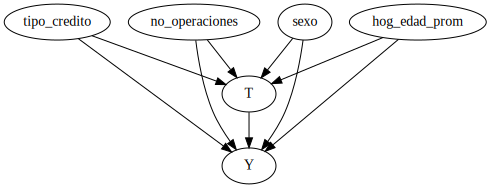


=== Identified Estimand (clean) ===
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                                             ↪
────(E[Y|W_credito_Microcredito,W_credito_TC,W_M,W_credito_Consumo,hog_edad_pr ↪
d[T]                                                                           ↪

↪                                                                     
↪ om,W_credito_Vivienda,no_operaciones__tipo__tipo__sexo__tipo__tipo])
↪                                                                     
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,W__tipo_credito_Microcredito,W__tipo_credito_TC,W__sexo_M,W__tipo_credito_Consumo,hog_edad_prom,W__tipo_credito_Vivienda,no_operaciones,U) = P(Y|T,W__tipo_credito_Microcredito,W__tipo_credito_TC,W__sexo_M,W__tipo_credito_Consumo,hog_edad_prom,W__tipo_credito_Vivienda,no_operaciones)

### Estimand : 2
Estimand name: iv
No such 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Causal Estimate (PS Stratification, clean) ===
ATE (T=1 vs T=0): 1,577,956,560.5741

=== Refutations (clean) ===
[Random common cause]
 Refute: Add a random common cause
Estimated effect:2358571331.518494
New effect:2358485634.9777904
p value:0.94


[Placebo treatment]
 Refute: Use a Placebo Treatment
Estimated effect:2358571331.518494
New effect:2516552.38764987
p value:0.96


[Bootstrap]
 Refute: Bootstrap Sample Dataset
Estimated effect:2358571331.518494
New effect:2100084264.4977221
p value:0.01


NOTAS:
- Merge prioriza llaves ['sexo'] (o más si existieran), sin duplicar filas.
- Se corrigen NaN/Inf y columnas constantes antes de estimar.
- Puedes añadir más controles (p. ej., educación) sumando su promedio ponderado y agregándolo a W.


In [ ]:
from IPython.display import display
import graphviz
from dowhy import CausalModel

# Parámetros base
DF_CARTERA = "CarteraTotalCategoria2.csv"   # cambia aquí si usamos otra
T_TREATED_VALUE  = "BANCOS COMERCIALES"
T_CONTROL_VALUE  = "OPDF DE PRIMER NIVEL"

# Utilidades
def _mount_and_basedir():
    try:
        return BASE_DIR
    except NameError:
        from google.colab import drive
        drive.mount('/content/drive')
        return "/content/drive/MyDrive/Base_datos"
BASE_DIR = _mount_and_basedir()

def _smart_read(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":  return pd.read_csv(path, encoding="utf-8", low_memory=False)
    if ext in (".xls",".xlsx"):  return pd.read_excel(path)
    if ext == ".sav":
        import pyreadstat
        df,_ = pyreadstat.read_sav(path, apply_value_formats=True)
        return df
    raise ValueError(f"Extensión no soportada: {ext}")

def _wmean(x, w):
    x = pd.to_numeric(x, errors="coerce"); w = pd.to_numeric(w, errors="coerce")
    m = x.notna() & w.notna()
    return float(np.sum(x[m]*w[m]) / np.sum(w[m])) if m.any() else np.nan

def _find_like(df, cands):
    low = {c.lower().strip(): c for c in df.columns}
    for k in cands:
        if k in low: return low[k]
    for c in df.columns:
        if any(k in c.lower().strip() for k in cands):
            return c
    return None

# Normaliza 'sexo' evitando DTypePromotionError
def _normalize_sexo_series(s: pd.Series) -> pd.Series:
    sc = pd.Series(s, copy=True).astype("string").str.strip().str.lower()
    map_dict = {
        "m": "M", "h": "M", "hombre": "M", "masculino": "M", "1": "M",
        "f": "F", "mujer": "F", "femenino": "F", "2": "F"
    }
    out = sc.map(map_dict).astype("object")
    upper = sc.str.upper()
    out[upper.eq("M")] = "M"
    out[upper.eq("F")] = "F"
    out[pd.isna(out)] = np.nan
    return out

def _is_categorical(s: pd.Series) -> bool:
    return (s.dtype == "object") or pd.api.types.is_string_dtype(s)

def _ohe(df, cols):
    cat_cols = [c for c in cols if c in df.columns and _is_categorical(df[c])]
    if not cat_cols:
        return df.copy(), cols
    dummies = pd.get_dummies(df[cat_cols], prefix=[f"W__{c}" for c in cat_cols], drop_first=True)
    out = pd.concat([df.drop(columns=cat_cols), dummies], axis=1)
    new_w = [c for c in cols if c not in cat_cols] + dummies.columns.tolist()
    return out, new_w

# Saneamiento para DoWhy
def sanitize_df_scm(df: pd.DataFrame, y: str, t: str, wcols: list):
    df2 = df.copy()

    # 1) Forzar numéricos donde aplica
    force_numeric = [c for c in [y, t, "no_operaciones", "hog_edad_prom",
                                 "hog_ingreso_total_prom", "hog_pea_rate", "hog_share_urbano"]
                     if c in df2.columns]
    for c in force_numeric:
        df2[c] = pd.to_numeric(df2[c], errors="coerce")

    # 2) Reemplazar inf/-inf por NaN
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 3) Imputaciones simples (para no perder filas)
    for c in ["hog_pea_rate", "hog_ingreso_total_prom", "hog_edad_prom", "hog_share_urbano"]:
        if c in df2.columns:
            mean_c = df2[c].mean(skipna=True)
            df2[c] = df2[c].fillna(mean_c)
    if "no_operaciones" in df2.columns:
        df2["no_operaciones"] = df2["no_operaciones"].fillna(df2["no_operaciones"].median())

    # 4) Eliminar filas con NA en variables esenciales (Y, T, W)
    essential = [y, t] + [c for c in wcols if c in df2.columns]
    before = len(df2)
    df2 = df2.dropna(subset=essential)
    print(f"[SANITY] Filas eliminadas por NA/inf en Y/T/W: {before - len(df2)}")

    # 5) Quitar columnas constantes de W
    const_cols = [c for c in wcols if c in df2.columns and df2[c].nunique(dropna=True) <= 1]
    if const_cols:
        print("[SANITY] Columnas constantes removidas de W:", const_cols)
        df2 = df2.drop(columns=const_cols, errors="ignore")
        wcols = [c for c in wcols if c not in const_cols]

    return df2, wcols

# Asegurar 'tablas' y cargar Hogares/Cartera si falta
try:
    tablas
except NameError:
    tablas = {}

# Hogares_2024
if "Hogares_2024" not in tablas:
    candidatos = ["Hogares_2024.xlsx","Hogares 2024.xlsx","Hogares_2024.sav","Hogares 2024.sav"]
    found = next((os.path.join(BASE_DIR, nm) for nm in candidatos if os.path.exists(os.path.join(BASE_DIR, nm))), None)
    if not found:
        raise FileNotFoundError(f"No encontré ninguno de {candidatos} en {BASE_DIR}")
    tablas["Hogares_2024"] = _smart_read(found)

# Cartera (si no está en 'tablas', intenta lectura directa)
if DF_CARTERA not in tablas:
    fpath = os.path.join(BASE_DIR, DF_CARTERA)
    assert os.path.exists(fpath), f"{DF_CARTERA} no está en 'tablas' ni en {BASE_DIR}"
    tablas[DF_CARTERA] = _smart_read(fpath)

# Normalizar Hogares
df_h = tablas["Hogares_2024"].copy()
if "factor_expansion" not in df_h.columns:
    df_h["factor_expansion"] = 1.0

# Reconstruir ingreso_total si falta
if "ingreso_total" not in df_h.columns and {"ingreso_laboral","ingreso_no_laboral"} <= set(df_h.columns):
    df_h["ingreso_total"] = pd.to_numeric(df_h["ingreso_laboral"], errors="coerce").fillna(0) + \
                            pd.to_numeric(df_h["ingreso_no_laboral"], errors="coerce").fillna(0)

for c in ["ingreso_total","ingreso_laboral","ingreso_no_laboral","edad","factor_expansion","pea"]:
    if c in df_h.columns:
        df_h[c] = pd.to_numeric(df_h[c], errors="coerce")

if "sexo" in df_h.columns:
    df_h["sexo"] = _normalize_sexo_series(df_h["sexo"])
if "area" in df_h.columns:
    ar = df_h["area"].astype(str).str.upper().str.strip()
    df_h["area"] = ar.replace({"1":"URBANO","U":"URBANO","URBANO":"URBANO",
                               "2":"RURAL","R":"RURAL","RURAL":"RURAL"})

#  Normalizar Cartera
df_c = tablas[DF_CARTERA].copy()
req_cols = {"tipo_institucion","saldo_cartera","tipo_credito","no_operaciones"}
missing = req_cols - set(df_c.columns)
assert not missing, f"Faltan columnas requeridas en {DF_CARTERA}: {missing}"

# Detectar/crear 'sexo' en cartera
col_c_sex = _find_like(df_c, ["sexo","genero","tipo_persona"," sexo","_sexo","genero_","_genero","tipo persona"])
if col_c_sex is not None:
    if col_c_sex != "sexo":
        df_c["sexo"] = _normalize_sexo_series(df_c[col_c_sex])
    else:
        df_c["sexo"] = _normalize_sexo_series(df_c["sexo"])

# Controles ponderados desde Hogares
keys_h = [k for k in ["sexo","region","area"] if k in df_h.columns]
if not keys_h:
    df_h["__llave_dummy__"] = "ALL"
    keys_h = ["__llave_dummy__"]

grp = df_h.groupby(keys_h, dropna=False)
controles = pd.DataFrame(index=grp.size().index).reset_index()

if "pea" in df_h.columns:
    controles["hog_pea_rate"] = grp.apply(
        lambda g: _wmean((g["pea"].fillna(0).astype(float) > 0).astype(float), g["factor_expansion"]),
        include_groups=False
    ).values
if "ingreso_total" in df_h.columns:
    controles["hog_ingreso_total_prom"] = grp.apply(
        lambda g: _wmean(g["ingreso_total"], g["factor_expansion"]),
        include_groups=False
    ).values
if "edad" in df_h.columns:
    controles["hog_edad_prom"] = grp.apply(
        lambda g: _wmean(g["edad"], g["factor_expansion"]),
        include_groups=False
    ).values
if "area" in df_h.columns:
    controles["hog_share_urbano"] = grp.apply(
        lambda g: _wmean((g["area"].astype(str)=="URBANO").astype(float), g["factor_expansion"]),
        include_groups=False
    ).values

print("[INFO] Controles hogares (muestra):")
display(controles.head())

# Llaves de cruce disponibles
prioridades = [
    ["sexo","region","area"],
    ["sexo","region"],
    ["sexo","area"],
    ["sexo"]
]
keys_candidatas = None
c_cols = set(df_c.columns)
h_cols = set(controles.columns)
for ks in prioridades:
    if set(ks).issubset(h_cols) and set(ks).issubset(c_cols):
        keys_candidatas = ks
        break
if keys_candidatas is None and "sexo" in df_c.columns and "sexo" in controles.columns:
    keys_candidatas = ["sexo"]

use_global_scalar = False
if keys_candidatas is None:
    use_global_scalar = True
    print("[AVISO] No hay llaves comunes; se aplicarán controles globales sin duplicar filas.")
else:
    print("[INFO] Llaves de merge seleccionadas:", keys_candidatas)

# Preparar contraste causal en cartera
mask = df_c["tipo_institucion"].isin([T_TREATED_VALUE, T_CONTROL_VALUE])
keep_cols = ["tipo_institucion","saldo_cartera","tipo_credito","no_operaciones"] + \
            [k for k in ["sexo","region","area"] if k in df_c.columns]
df2 = df_c.loc[mask, keep_cols].dropna(subset=["saldo_cartera","tipo_credito","no_operaciones"]).copy()

# Merge de controles (sin duplicar)
if not use_global_scalar:
    n_before = df2.shape[0]
    df2 = df2.merge(controles, on=keys_candidatas, how="left")
    print(f"[MERGE] Filas antes/después del merge: {n_before} → {df2.shape[0]}")
else:
    # Asigna un valor global (promedio de los controles) sin duplicar filas
    vals = {}
    for c in ["hog_pea_rate","hog_ingreso_total_prom","hog_edad_prom","hog_share_urbano"]:
        if c in controles.columns and not controles[c].dropna().empty:
            vals[c] = float(controles[c].dropna().mean())
    for k,v in vals.items(): df2[k] = v
    print("[MERGE] Controles globales asignados sin duplicar filas.")

# Preparar SCM
df2["T"] = (df2["tipo_institucion"] == T_TREATED_VALUE).astype(int)
df2 = df2.rename(columns={"saldo_cartera":"Y"})
W_base = ["tipo_credito","no_operaciones"] + [k for k in ["sexo","region","area"] if k in df2.columns]
W_hog  = [c for c in ["hog_pea_rate","hog_ingreso_total_prom","hog_edad_prom","hog_share_urbano"] if c in df2.columns]
W = W_base + W_hog

df_scm, W_encoded = _ohe(df2, W)

print("\n=== RESUMEN SCM ===")
print("W (original):", W)
print("W (codificado):", W_encoded)
print("df_scm shape:", df_scm.shape)

# Saneamiento previo a DoWhy
df_scm_clean, W_encoded_clean = sanitize_df_scm(df_scm, y="Y", t="T", wcols=W_encoded)
print("df_scm_clean shape:", df_scm_clean.shape)
print("W_encoded_clean (n):", len(W_encoded_clean))

# DAG
nodes = ["T","Y","tipo_credito","no_operaciones"] + [k for k in ["sexo","region","area"] if k in df2.columns]
edges = [("tipo_credito","Y"), ("no_operaciones","Y"), ("tipo_credito","T"), ("no_operaciones","T"), ("T","Y")]
for k in ["sexo","region","area"]:
    if k in df2.columns: edges += [(k,"T"), (k,"Y")]
for c in W_hog:
    nodes.append(c); edges += [(c,"T"), (c,"Y")]

dot = graphviz.Digraph(format="png")
for n in nodes: dot.node(n)
for a,b in edges: dot.edge(a,b)
display(dot)

# DoWhy (con datos limpios)
model = CausalModel(
    data=df_scm_clean,
    treatment="T",
    outcome="Y",
    common_causes=W_encoded_clean
)

identified_estimand = model.identify_effect()
print("\n=== Identified Estimand (clean) ===")
print(identified_estimand)

estimate_lin = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("\n=== Causal Estimate (Linear Regression, clean) ===")
print(f"ATE (T=1 vs T=0): {estimate_lin.value:,.4f}")

estimate_ps = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification"
)
print("\n=== Causal Estimate (PS Stratification, clean) ===")
print(f"ATE (T=1 vs T=0): {estimate_ps.value:,.4f}")

print("\n=== Refutations (clean) ===")
ref1 = model.refute_estimate(identified_estimand, estimate_lin, method_name="random_common_cause")
print("[Random common cause]\n", ref1)
ref2 = model.refute_estimate(identified_estimand, estimate_lin, method_name="placebo_treatment_refuter")
print("\n[Placebo treatment]\n", ref2)
ref3 = model.refute_estimate(identified_estimand, estimate_lin, method_name="bootstrap_refuter", num_simulations=200)
print("\n[Bootstrap]\n", ref3)

print("\nNOTAS:")
print("- Merge prioriza llaves ['sexo'] (o más si existieran), sin duplicar filas.")
print("- Se corrigen NaN/Inf y columnas constantes antes de estimar.")
print("- Puedes añadir más controles (p. ej., educación) sumando su promedio ponderado y agregándolo a W.")



In [ ]:
# 1) Construir (si existen) controles adicionales por SEXO a partir de df_h (Hogares)
def _wmean(x, w):
    x = pd.to_numeric(x, errors="coerce"); w = pd.to_numeric(w, errors="coerce")
    m = x.notna() & w.notna()
    return float(np.sum(x[m]*w[m]) / np.sum(w[m])) if m.any() else np.nan

assert 'df_h' in globals(), "No encuentro df_h (Hogares). Vuelve a ejecutar el bloque anterior."
assert 'df2'  in globals(), "No encuentro df2 (cartera ya cruzada). Vuelve a ejecutar el bloque anterior."

extra_ctrl = []
if 'sexo' in df_h.columns:
    grp = df_h.groupby('sexo', dropna=False)
    if 'pea' in df_h.columns:
        hog_pea_rate_by_sex = grp.apply(lambda g: _wmean((g['pea'].fillna(0).astype(float) > 0).astype(float),
                                                         g['factor_expansion'])).rename('hog_pea_rate').reset_index()
        extra_ctrl.append(hog_pea_rate_by_sex)
    if 'ingreso_total' in df_h.columns:
        hog_ing_by_sex = grp.apply(lambda g: _wmean(g['ingreso_total'], g['factor_expansion'])
                                  ).rename('hog_ingreso_total_prom').reset_index()
        extra_ctrl.append(hog_ing_by_sex)

if extra_ctrl:
    extra = extra_ctrl[0]
    for e in extra_ctrl[1:]:
        extra = extra.merge(e, on='sexo', how='outer')
    # merge no-duplicador por sexo: sobreescribe solo si no estaban ya
    cols_to_add = [c for c in ['hog_pea_rate','hog_ingreso_total_prom'] if c in extra.columns]
    df2 = df2.drop(columns=[c for c in cols_to_add if c in df2.columns], errors='ignore').merge(extra, on='sexo', how='left')
    print("[MEJORA] Controles extra incorporados desde Hogares por sexo:", cols_to_add)
else:
    print("[MEJORA] No se hallaron columnas en Hogares para agregar (pea/ingreso_total).")

# 2) Reconstruir W y hacer one-hot nuevamente
def _is_categorical(s: pd.Series) -> bool:
    return (s.dtype == "object") or pd.api.types.is_string_dtype(s)

def _ohe(df, cols):
    cat_cols = [c for c in cols if c in df.columns and _is_categorical(df[c])]
    if not cat_cols:
        return df.copy(), cols
    dummies = pd.get_dummies(df[cat_cols], prefix=[f"W__{c}" for c in cat_cols], drop_first=True)
    out = pd.concat([df.drop(columns=cat_cols), dummies], axis=1)
    new_w = [c for c in cols if c not in cat_cols] + dummies.columns.tolist()
    return out, new_w

W_base = ["tipo_credito","no_operaciones"] + [k for k in ["sexo","region","area"] if k in df2.columns]
W_hog  = [c for c in ["hog_pea_rate","hog_ingreso_total_prom","hog_edad_prom","hog_share_urbano"] if c in df2.columns]
W_all  = W_base + W_hog
df_scm2, W_encoded2 = _ohe(df2, W_all)

# 3) Saneamiento (reutiliza tu función si existe; si no, versión inline)
def sanitize_df_scm(df: pd.DataFrame, y: str, t: str, wcols: list):
    df2 = df.copy()
    for c in [y, t, "no_operaciones", "hog_edad_prom", "hog_pea_rate", "hog_ingreso_total_prom", "hog_share_urbano"]:
        if c in df2.columns: df2[c] = pd.to_numeric(df2[c], errors="coerce")
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    for c in ["hog_pea_rate","hog_ingreso_total_prom","hog_edad_prom","hog_share_urbano"]:
        if c in df2.columns: df2[c] = df2[c].fillna(df2[c].mean(skipna=True))
    if "no_operaciones" in df2.columns:
        df2["no_operaciones"] = df2["no_operaciones"].fillna(df2["no_operaciones"].median())
    essential = [y, t] + [c for c in wcols if c in df2.columns]
    before = len(df2); df2 = df2.dropna(subset=essential)
    print(f"[SANITY+] Filas eliminadas por NA/inf en Y/T/W: {before - len(df2)}")
    const_cols = [c for c in wcols if c in df2.columns and df2[c].nunique(dropna=True) <= 1]
    if const_cols:
        print("[SANITY+] Columnas constantes removidas de W:", const_cols)
        df2 = df2.drop(columns=const_cols, errors="ignore")
        wcols = [c for c in wcols if c not in const_cols]
    return df2, wcols

df_scm2_clean, W_encoded2_clean = sanitize_df_scm(df_scm2, "Y", "T", W_encoded2)
print("df_scm2_clean:", df_scm2_clean.shape, "| W_encoded2_clean (n):", len(W_encoded2_clean))

# 4) ESTIMAR con Y original y con Y_log
def run_dowhy(df_in, W_in, label):
    print(f"\n===== DoWhy ({label}) =====")
    model = CausalModel(data=df_in, treatment="T", outcome="Y", common_causes=W_in)
    identified = model.identify_effect()
    print(identified)

    est_lin = model.estimate_effect(identified, method_name="backdoor.linear_regression")
    print("ATE (Linear):", f"{est_lin.value:,.4f}")

    est_psw = model.estimate_effect(identified, method_name="backdoor.propensity_score_weighting")
    print("ATE (PS Weighting):", f"{est_psw.value:,.4f}")

    est_psm = model.estimate_effect(identified, method_name="backdoor.propensity_score_matching")
    print("ATE (PS Matching):", f"{est_psm.value:,.4f}")

    # refutadores
    r1 = model.refute_estimate(identified, est_lin, method_name="random_common_cause")
    print("\n[Refuter] random_common_cause\n", r1)
    r2 = model.refute_estimate(identified, est_lin, method_name="placebo_treatment_refuter")
    print("\n[Refuter] placebo_treatment\n", r2)
    r3 = model.refute_estimate(identified, est_lin, method_name="bootstrap_refuter", num_simulations=300)
    print("\n[Refuter] bootstrap_refuter\n", r3)

# Y original
run_dowhy(df_scm2_clean, W_encoded2_clean, "Y original")

# 5) Outcome log-transformado
df_log = df_scm2_clean.copy()
df_log["Y"] = np.log1p(df_log["Y"].astype(float))
run_dowhy(df_log, W_encoded2_clean, "log1p(Y)")
# =============================================================================


[MEJORA] No se hallaron columnas en Hogares para agregar (pea/ingreso_total).
[SANITY+] Filas eliminadas por NA/inf en Y/T/W: 0
df_scm2_clean: (8935, 10) | W_encoded2_clean (n): 7

===== DoWhy (Y original) =====
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                                             ↪
────(E[Y|W_credito_Microcredito,W_credito_TC,W_M,W_credito_Consumo,hog_edad_pr ↪
d[T]                                                                           ↪

↪                                                                     
↪ om,W_credito_Vivienda,no_operaciones__tipo__tipo__sexo__tipo__tipo])
↪                                                                     
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,W__tipo_credito_Microcredito,W__tipo_credito_TC,W__sexo_M,W__tipo_credito_Consumo,hog_edad_prom,W__tipo_credito_Vivienda,no_operaciones,U) = P(Y|T,W__tip

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ATE (PS Weighting): 2,845,413,252.1668
ATE (PS Matching): 2,438,335,831.0765

[Refuter] random_common_cause
 Refute: Add a random common cause
Estimated effect:2358571331.518494
New effect:2358636053.7297044
p value:0.8600000000000001


[Refuter] placebo_treatment
 Refute: Use a Placebo Treatment
Estimated effect:2358571331.518494
New effect:2992250.1261062957
p value:1.0




[Refuter] bootstrap_refuter
 Refute: Bootstrap Sample Dataset
Estimated effect:2358571331.518494
New effect:2110811737.4912298
p value:0.006666666666666667


===== DoWhy (log1p(Y)) =====
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                                             ↪
────(E[Y|W_credito_Microcredito,W_credito_TC,W_M,W_credito_Consumo,hog_edad_pr ↪
d[T]                                                                           ↪

↪                                                                     
↪ om,W_credito_Vivienda,no_operaciones__tipo__tipo__sexo__tipo__tipo])
↪                                                                     
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,W__tipo_credito_Microcredito,W__tipo_credito_TC,W__sexo_M,W__tipo_credito_Consumo,hog_edad_prom,W__tipo_credito_Vivienda,no_operaciones,U) = P(Y|T,W__tipo_credito_Microcredito,W

## Validación causal con “cross-fitting”

In [ ]:
# ======================= CROSS-FITTING PARA ATE (IPW y AIPW) =======================
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor

# ---- Validaciones mínimas: usa lo preparado por tu pipeline SCM ----
assert 'df_scm_clean' in globals() and isinstance(df_scm_clean, pd.DataFrame), "Necesito df_scm_clean (del bloque SCM limpio)."
assert 'W_encoded_clean' in globals() and isinstance(W_encoded_clean, (list, tuple)) and len(W_encoded_clean)>0, "Necesito W_encoded_clean."

DF = df_scm_clean.copy()
Y_col, T_col, W_cols = "Y", "T", list(W_encoded_clean)

# Asegurar tipos/ausentes
DF = DF[[Y_col, T_col] + W_cols].copy()
for c in [Y_col, T_col] + W_cols:
    DF[c] = pd.to_numeric(DF[c], errors="coerce")
DF.dropna(subset=[Y_col, T_col] + W_cols, inplace=True)
DF[T_col] = DF[T_col].astype(int)

print(f"[CF] n={len(DF)} | W={len(W_cols)}")

# ---- Modelos base ----
# Propensión: logística con regularización
propensity_model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False por matrices dispersas/one-hot
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
# Resultados: dos modelos (T=1 y T=0)
# Usa un modelo robusto a no linealidades; si quieres algo más rápido, cambia a Ridge(alpha=5.0)
outcome_model_1 = GradientBoostingRegressor(random_state=42)
outcome_model_0 = GradientBoostingRegressor(random_state=42)

# ---- Función principal: cross-fitting ----
def crossfit_ate(df, y_col, t_col, w_cols, K=5, eps=1e-3,
                 prop_model=None, y_model_1=None, y_model_0=None, random_state=42):
    df = df[[y_col, t_col] + w_cols].copy()
    y = df[y_col].to_numpy(float)
    t = df[t_col].to_numpy(int)
    X = df[w_cols].to_numpy(float)

    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=random_state)

    # Acumuladores por fold
    ipw_terms = []
    aipw_terms = []

    for k, (tr, te) in enumerate(skf.split(X, t), start=1):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]
        t_tr, t_te = t[tr], t[te]

        # 1) Propensión: entrenar en train, predecir en test
        pm = prop_model
        pm.fit(X_tr, t_tr)
        p_te = pm.predict_proba(X_te)[:, 1].astype(float)
        p_te = np.clip(p_te, eps, 1 - eps)

        # 2) Modelos de resultado por brazo (entrenados en train)
        m1 = y_model_1
        m0 = y_model_0
        m1.fit(X_tr[t_tr==1], y_tr[t_tr==1])
        m0.fit(X_tr[t_tr==0], y_tr[t_tr==0])

        mu1_te = m1.predict(X_te).astype(float)
        mu0_te = m0.predict(X_te).astype(float)

        # 3) Estimadores por fold
        #    IPW (ATE) = mean( T*Y/p - (1-T)*Y/(1-p) )
        ipw_fold = np.mean( t_te * y_te / p_te - (1 - t_te) * y_te / (1 - p_te) )
        ipw_terms.append((ipw_fold, len(te)))

        #    AIPW (Doubly Robust)
        psi = (mu1_te - mu0_te) + t_te * (y_te - mu1_te) / p_te - (1 - t_te) * (y_te - mu0_te) / (1 - p_te)
        aipw_terms.append((psi, len(te)))

        print(f"[CF] Fold {k}/{K} | IPW={ipw_fold:,.4f} | p̂ mean={p_te.mean():.3f}")

    # Concatenar ψ para varianza robusta
    psi_all = np.concatenate([psi for psi, _ in aipw_terms])
    ate_aipw = float(np.mean(psi_all))
    se_aipw  = float(np.std(psi_all, ddof=1) / np.sqrt(len(psi_all)))
    ci_aipw  = (ate_aipw - 1.96*se_aipw, ate_aipw + 1.96*se_aipw)

    # Promedio simple de IPW por fold (también puedes recomputar IPW global con p̂ out-of-fold)
    ipw_vals = np.array([v for v,_ in ipw_terms])
    ate_ipw  = float(ipw_vals.mean())

    return {
        "ATE_IPW": ate_ipw,
        "ATE_AIPW": ate_aipw,
        "SE_AIPW": se_aipw,
        "CI95_AIPW": ci_aipw
    }

# ---- Ejecutar cross-fitting ----
results_cf = crossfit_ate(
    DF, Y_col, T_col, W_cols, K=5, eps=1e-3,
    prop_model=propensity_model,
    y_model_1=outcome_model_1,
    y_model_0=outcome_model_0,
    random_state=42
)

print("\n===== RESULTADOS CROSS-FITTING =====")
print(f"ATE (IPW)        : {results_cf['ATE_IPW']:,.6f}")
print(f"ATE (AIPW, CF)   : {results_cf['ATE_AIPW']:,.6f}")
print(f"SE  (AIPW, CF)   : {results_cf['SE_AIPW']:,.6f}")
print(f"CI95(AIPW, CF)   : [{results_cf['CI95_AIPW'][0]:,.6f}, {results_cf['CI95_AIPW'][1]:,.6f}]")


[CF] n=8935 | W=7
[CF] Fold 1/5 | IPW=3,050,767,062.8536 | p̂ mean=0.580
[CF] Fold 2/5 | IPW=3,237,664,391.1064 | p̂ mean=0.565
[CF] Fold 3/5 | IPW=3,104,024,471.7494 | p̂ mean=0.573
[CF] Fold 4/5 | IPW=3,211,015,993.3570 | p̂ mean=0.572
[CF] Fold 5/5 | IPW=2,981,016,937.4547 | p̂ mean=0.552

===== RESULTADOS CROSS-FITTING =====
ATE (IPW)        : 3,116,897,771.304219
ATE (AIPW, CF)   : 2,145,504,937.871114
SE  (AIPW, CF)   : 67,314,904.647362
CI95(AIPW, CF)   : [2,013,567,724.762284, 2,277,442,150.979943]


In [ ]:
# ---- Diagnóstico rápido de propensión out-of-fold (opcional) ----
# Distribución aproximada de p̂ por grupo T
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
p_all = np.zeros(len(DF))
for tr, te in skf.split(DF[W_cols], DF[T_col]):
     propensity_model.fit(DF[W_cols].iloc[tr], DF[T_col].iloc[tr])
     p_all[te] = propensity_model.predict_proba(DF[W_cols].iloc[te])[:,1]
print("Propensión media | T=1:", p_all[DF[T_col]==1].mean(), " | T=0:", p_all[DF[T_col]==0].mean())
# ======================= FIN CROSS-FITTING =======================

Propensión media | T=1: 0.6653810275306238  | T=0: 0.33508961439245805


In [ ]:
# HETEROGENEIDAD DEL EFECTO POR SEXO (CROSS-FITTING)
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

# --- Comprobaciones mínimas (usa objetos del bloque anterior) ---
assert 'df_scm_clean' in globals() and isinstance(df_scm_clean, pd.DataFrame), "Falta df_scm_clean"
assert 'W_encoded_clean' in globals() and isinstance(W_encoded_clean, (list, tuple)) and len(W_encoded_clean)>0, "Falta W_encoded_clean"

DF = df_scm_clean.copy()
Y_col, T_col = "Y", "T"

# --- Detectar indicador binario de sexo (1=M, 0=F) ---
sex_indicator_col = None
if "W__sexo_M" in DF.columns:
    sex_indicator_col = "W__sexo_M"
elif "sexo" in DF.columns:  # por si no se hizo one-hot
    s = DF["sexo"].astype(str).str.upper().str.strip()
    DF["W__sexo_M"] = (s == "M").astype(int)
    sex_indicator_col = "W__sexo_M"

assert sex_indicator_col is not None, "No encontré columna de sexo (W__sexo_M o sexo)."

# --- Función cross-fitting (IPW y AIPW), devolviendo también SE e IF para CI y diferencias ---
def crossfit_ate(df, y_col, t_col, w_cols, K=5, eps=1e-3, random_state=42):
    """Devuelve dict con ATE_IPW, ATE_AIPW, SE_AIPW, CI95_AIPW y n."""
    # Modelos base
    prop_model = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("lr", LogisticRegression(max_iter=3000, class_weight="balanced"))
    ])
    m1 = GradientBoostingRegressor(random_state=42)
    m0 = GradientBoostingRegressor(random_state=42)

    df = df[[y_col, t_col] + w_cols].copy()
    for c in [y_col, t_col] + w_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df.dropna(subset=[y_col, t_col] + w_cols, inplace=True)
    df[t_col] = df[t_col].astype(int)

    y = df[y_col].to_numpy(float)
    t = df[t_col].to_numpy(int)
    X = df[w_cols].to_numpy(float)

    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=random_state)

    ipw_vals = []
    psi_all = np.empty(0, dtype=float)

    for k, (tr, te) in enumerate(skf.split(X, t), start=1):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]
        t_tr, t_te = t[tr], t[te]

        # Propensión out-of-fold
        prop_model.fit(X_tr, t_tr)
        p_te = prop_model.predict_proba(X_te)[:, 1].astype(float)
        p_te = np.clip(p_te, eps, 1-eps)

        # Modelos de resultado por brazo
        m1.fit(X_tr[t_tr==1], y_tr[t_tr==1])
        m0.fit(X_tr[t_tr==0], y_tr[t_tr==0])
        mu1_te = m1.predict(X_te).astype(float)
        mu0_te = m0.predict(X_te).astype(float)

        # IPW fold
        ipw_fold = np.mean(t_te*y_te/p_te - (1-t_te)*y_te/(1-p_te))
        ipw_vals.append(ipw_fold)

        # AIPW IF (psi)
        psi = (mu1_te - mu0_te) + t_te*(y_te - mu1_te)/p_te - (1-t_te)*(y_te - mu0_te)/(1-p_te)
        psi_all = np.concatenate([psi_all, psi])

        print(f"[SEX-CF] Fold {k}/{K} | p̂ mean={p_te.mean():.3f}")

    ate_ipw = float(np.mean(ipw_vals))
    ate_aipw = float(np.mean(psi_all))
    n = psi_all.size
    se_aipw = float(np.std(psi_all, ddof=1) / np.sqrt(n)) if n>1 else np.nan
    ci_aipw = (ate_aipw - 1.96*se_aipw, ate_aipw + 1.96*se_aipw) if np.isfinite(se_aipw) else (np.nan, np.nan)
    return {"ATE_IPW": ate_ipw, "ATE_AIPW": ate_aipw, "SE_AIPW": se_aipw, "CI95_AIPW": ci_aipw, "n": n}

# --- Construir listas de W para cada subgrupo (quitando sexo para no "reajustar" dentro del subgrupo) ---
W_all = list(W_encoded_clean)
W_no_sex = [c for c in W_all if not c.startswith("W__sexo_") and c != "sexo"]

# --- Subconjuntos: Mujeres (0) y Hombres (1) ---
mask_M = DF[sex_indicator_col] == 1
mask_F = DF[sex_indicator_col] == 0

DF_M = DF.loc[mask_M].copy()
DF_F = DF.loc[mask_F].copy()

print(f"[INFO] Tamaños subgrupos → Mujeres: {DF_F.shape[0]} | Hombres: {DF_M.shape[0]}")

# --- ATE por subgrupo (AIPW + IPW) ---
res_F = crossfit_ate(DF_F, Y_col, T_col, W_no_sex, K=5, eps=1e-3, random_state=42)
res_M = crossfit_ate(DF_M, Y_col, T_col, W_no_sex, K=5, eps=1e-3, random_state=42)

print("\n===== RESULTADOS HETEROGENEIDAD POR SEXO =====")
print(f"Mujeres  | n={res_F['n']} | ATE_IPW={res_F['ATE_IPW']:,.4f} | ATE_AIPW={res_F['ATE_AIPW']:,.4f} | SE={res_F['SE_AIPW']:,.4f} | CI95={res_F['CI95_AIPW'][0]:,.4f} .. {res_F['CI95_AIPW'][1]:,.4f}")
print(f"Hombres  | n={res_M['n']} | ATE_IPW={res_M['ATE_IPW']:,.4f} | ATE_AIPW={res_M['ATE_AIPW']:,.4f} | SE={res_M['SE_AIPW']:,.4f} | CI95={res_M['CI95_AIPW'][0]:,.4f} .. {res_M['CI95_AIPW'][1]:,.4f}")

# --- Diferencia de efectos: ΔATE = ATE_Hombres − ATE_Mujeres (aprox. varianzas independientes) ---
delta = res_M["ATE_AIPW"] - res_F["ATE_AIPW"]
se_delta = np.sqrt(res_M["SE_AIPW"]**2 + res_F["SE_AIPW"]**2) if np.isfinite(res_M["SE_AIPW"]) and np.isfinite(res_F["SE_AIPW"]) else np.nan
ci_delta = (delta - 1.96*se_delta, delta + 1.96*se_delta) if np.isfinite(se_delta) else (np.nan, np.nan)

print(f"\nΔATE (H − M) = {delta:,.4f}")
print(f"SE(Δ)        = {se_delta:,.4f}")
print(f"CI95(Δ)      = [{ci_delta[0]:,.4f}, {ci_delta[1]:,.4f}]")

# --- Repetir en escala log: outcome log1p(Y) para comparar ---
RUN_LOG = False
if RUN_LOG:
    DF_F_log = DF_F.copy(); DF_F_log["Y"] = np.log1p(DF_F_log["Y"].astype(float))
    DF_M_log = DF_M.copy(); DF_M_log["Y"] = np.log1p(DF_M_log["Y"].astype(float))
    res_F_log = crossfit_ate(DF_F_log, Y_col, T_col, W_no_sex, K=5, eps=1e-3, random_state=42)
    res_M_log = crossfit_ate(DF_M_log, Y_col, T_col, W_no_sex, K=5, eps=1e-3, random_state=42)
    print("\n--- Escala log1p(Y) ---")
    print(f"Mujeres  | ATE_AIPW_log={res_F_log['ATE_AIPW']:,.6f}")
    print(f"Hombres  | ATE_AIPW_log={res_M_log['ATE_AIPW']:,.6f}")
    print(f"ΔATE_log = {res_M_log['ATE_AIPW'] - res_F_log['ATE_AIPW']:,.6f}")
# ======================= FIN HETEROGENEIDAD POR SEXO =======================


[INFO] Tamaños subgrupos → Mujeres: 5182 | Hombres: 3753
[SEX-CF] Fold 1/5 | p̂ mean=0.581
[SEX-CF] Fold 2/5 | p̂ mean=0.579
[SEX-CF] Fold 3/5 | p̂ mean=0.586
[SEX-CF] Fold 4/5 | p̂ mean=0.575
[SEX-CF] Fold 5/5 | p̂ mean=0.584
[SEX-CF] Fold 1/5 | p̂ mean=0.559
[SEX-CF] Fold 2/5 | p̂ mean=0.552
[SEX-CF] Fold 3/5 | p̂ mean=0.556
[SEX-CF] Fold 4/5 | p̂ mean=0.552
[SEX-CF] Fold 5/5 | p̂ mean=0.536

===== RESULTADOS HETEROGENEIDAD POR SEXO =====
Mujeres  | n=5182 | ATE_IPW=2,881,353,563.0587 | ATE_AIPW=2,146,304,428.4641 | SE=82,462,667.0624 | CI95=1,984,677,601.0218 .. 2,307,931,255.9064
Hombres  | n=3753 | ATE_IPW=3,395,298,277.8108 | ATE_AIPW=2,471,611,657.2301 | SE=106,958,990.1009 | CI95=2,261,972,036.6324 .. 2,681,251,277.8278

ΔATE (H − M) = 325,307,228.7660
SE(Δ)        = 135,056,717.7983
CI95(Δ)      = [60,596,061.8813, 590,018,395.6506]


ΔATE = 325,307,229 | SE = 135,056,718 | z = 2.41 | p-value = 0.0160
ATE Mujeres como % del saldo medio control (Mujeres): 1984.68%
ATE Hombres como % del saldo medio control (Hombres): 1580.62%

Resumen:
   Grupo    n     ATE_AIPW           SE       CI_low      CI_high  ATE_%_sobre_media_control
Mujeres 5182 2.146304e+09 8.246267e+07 1.984678e+09 2.307931e+09                1984.681215
Hombres 3753 2.471612e+09 1.069590e+08 2.261972e+09 2.681251e+09                1580.617125
 Δ(H−M) 8935 3.253072e+08 1.350567e+08 6.059606e+07 5.900184e+08                        NaN


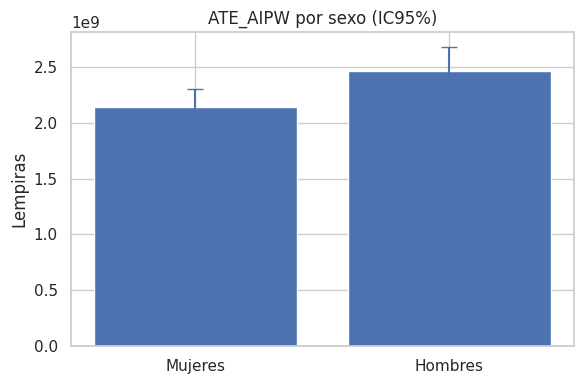

In [ ]:
# ================== RESUMEN + PRUEBA WALD + % DEL SALDO MEDIO ==================
res_F = {
    "n": 5182,
    "ATE_AIPW": 2_146_304_428.4641,
    "SE_AIPW": 82_462_667.0624,
    "CI95_AIPW": (1_984_677_601.0218, 2_307_931_255.9064),
}
res_M = {
    "n": 3753,
    "ATE_AIPW": 2_471_611_657.2301,
    "SE_AIPW": 106_958_990.1009,
    "CI95_AIPW": (2_261_972_036.6324, 2_681_251_277.8278),
}
delta = 325_307_228.7660
se_delta = 135_056_717.7983
ci_delta = (60_596_061.8813, 590_018_395.6506)

# p-value Wald para ΔATE (H−M)
from math import erf, sqrt
z = delta / se_delta
p_two_sided = 2*(1 - 0.5*(1+erf(abs(z)/sqrt(2))))
print(f"ΔATE = {delta:,.0f} | SE = {se_delta:,.0f} | z = {z:.2f} | p-value = {p_two_sided:.4f}")

# % del saldo medio por sexo (usa tus datos limpios ya creados)
assert 'df_scm_clean' in globals(), "Necesito df_scm_clean"
# saldo medio en control (T=0) como base
meanY_F = df_scm_clean.loc[(df_scm_clean.get('W__sexo_M',0)==0) & (df_scm_clean['T']==0), 'Y'].mean()
meanY_M = df_scm_clean.loc[(df_scm_clean.get('W__sexo_M',0)==1) & (df_scm_clean['T']==0), 'Y'].mean()
pct_F = 100 * res_F["ATE_AIPW"] / meanY_F if np.isfinite(meanY_F) and meanY_F>0 else np.nan
pct_M = 100 * res_M["ATE_AIPW"] / meanY_M if np.isfinite(meanY_M) and meanY_M>0 else np.nan
print(f"ATE Mujeres como % del saldo medio control (Mujeres): {pct_F:.2f}%")
print(f"ATE Hombres como % del saldo medio control (Hombres): {pct_M:.2f}%")

# Tabla resumen
summary = pd.DataFrame([
    ["Mujeres", res_F["n"], res_F["ATE_AIPW"], res_F["SE_AIPW"], *res_F["CI95_AIPW"], pct_F],
    ["Hombres", res_M["n"], res_M["ATE_AIPW"], res_M["SE_AIPW"], *res_M["CI95_AIPW"], pct_M],
    ["Δ(H−M)", res_F["n"]+res_M["n"], delta, se_delta, *ci_delta, np.nan],
], columns=["Grupo","n","ATE_AIPW","SE","CI_low","CI_high","ATE_%_sobre_media_control"])
print("\nResumen:\n", summary.to_string(index=False))

# Gráfico barras con IC95%
labels = ["Mujeres","Hombres"]
ates = [res_F["ATE_AIPW"], res_M["ATE_AIPW"]]
los  = [res_F["CI95_AIPW"][0], res_M["CI95_AIPW"][0]]
his  = [res_F["CI95_AIPW"][1], res_M["CI95_AIPW"][1]]
err_low  = np.array(ates) - np.array(los)
err_high = np.array(his) - np.array(ates)

plt.figure(figsize=(6,4))
plt.bar(labels, ates)
plt.errorbar(labels, ates, yerr=[err_low, err_high], fmt='none', capsize=6)
plt.title("ATE_AIPW por sexo (IC95%)")
plt.ylabel("Lempiras")
plt.tight_layout()
plt.show()
# ========================================================================


In [ ]:
# ======================= TRIMMING POR PROPENSIÓN + HETEROGENEIDAD POR SEXO =======================

# --- Requisitos del pipeline previo ---
assert 'df_scm_clean' in globals() and isinstance(df_scm_clean, pd.DataFrame), "Falta df_scm_clean"
assert 'W_encoded_clean' in globals() and isinstance(W_encoded_clean, (list, tuple)) and len(W_encoded_clean)>0, "Falta W_encoded_clean"

DF = df_scm_clean.copy()
Y_col, T_col = "Y", "T"

# --- Identificador de sexo binario (1=Hombre, 0=Mujer) ---
if "W__sexo_M" in DF.columns:
    sex_indicator_col = "W__sexo_M"
elif "sexo" in DF.columns:
    s = DF["sexo"].astype(str).str.upper().str.strip()
    DF["W__sexo_M"] = (s == "M").astype(int)
    sex_indicator_col = "W__sexo_M"
else:
    raise RuntimeError("No encuentro una columna de sexo (W__sexo_M o sexo).")

# --- Construir lista de W para el modelo de propensión (excluyendo el propio sexo si estimamos por subgrupo) ---
W_all = list(W_encoded_clean)
W_no_sex = [c for c in W_all if not c.startswith("W__sexo_") and c != "sexo"]

# --- Propensión out-of-fold (para TRIMMING) ---
def oof_propensity(df, t_col, w_cols, K=5, random_state=42):
    """Devuelve un vector p̂ OOF (out-of-fold) con la misma longitud que df."""
    X = df[w_cols].apply(pd.to_numeric, errors='coerce').to_numpy(float)
    t = pd.to_numeric(df[t_col], errors='coerce').astype(int).to_numpy()
    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=random_state)
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("lr", LogisticRegression(max_iter=3000, class_weight="balanced"))
    ])
    p_all = np.zeros(len(df), dtype=float)
    for tr, te in skf.split(X, t):
        pipe.fit(X[tr], t[tr])
        p_all[te] = pipe.predict_proba(X[te])[:,1]
    return np.clip(p_all, 1e-3, 1-1e-3)

# --- Cross-fitting ATE (IPW y AIPW) en un df ya filtrado ---
def crossfit_ate(df, y_col, t_col, w_cols, K=5, eps=1e-3, random_state=42):
    prop_model = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("lr", LogisticRegression(max_iter=3000, class_weight="balanced"))
    ])
    m1 = GradientBoostingRegressor(random_state=42)
    m0 = GradientBoostingRegressor(random_state=42)

    df = df[[y_col, t_col] + w_cols].copy()
    for c in [y_col, t_col] + w_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df.dropna(subset=[y_col, t_col] + w_cols, inplace=True)
    df[t_col] = df[t_col].astype(int)

    y = df[y_col].to_numpy(float)
    t = df[t_col].to_numpy(int)
    X = df[w_cols].to_numpy(float)

    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=random_state)
    ipw_vals, psi_all = [], np.empty(0, dtype=float)

    for k, (tr, te) in enumerate(skf.split(X, t), start=1):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]
        t_tr, t_te = t[tr], t[te]

        prop_model.fit(X_tr, t_tr)
        p_te = np.clip(prop_model.predict_proba(X_te)[:,1], eps, 1-eps)

        m1.fit(X_tr[t_tr==1], y_tr[t_tr==1])
        m0.fit(X_tr[t_tr==0], y_tr[t_tr==0])
        mu1_te = m1.predict(X_te).astype(float)
        mu0_te = m0.predict(X_te).astype(float)

        ipw_vals.append(np.mean(t_te*y_te/p_te - (1-t_te)*y_te/(1-p_te)))
        psi = (mu1_te - mu0_te) + t_te*(y_te - mu1_te)/p_te - (1-t_te)*(y_te - mu0_te)/(1-p_te)
        psi_all = np.concatenate([psi_all, psi])

    ate_ipw  = float(np.mean(ipw_vals))
    ate_aipw = float(np.mean(psi_all))
    n = psi_all.size
    se_aipw = float(np.std(psi_all, ddof=1)/np.sqrt(n)) if n>1 else np.nan
    ci_aipw = (ate_aipw - 1.96*se_aipw, ate_aipw + 1.96*se_aipw) if np.isfinite(se_aipw) else (np.nan, np.nan)
    return {"ATE_IPW": ate_ipw, "ATE_AIPW": ate_aipw, "SE_AIPW": se_aipw, "CI95_AIPW": ci_aipw, "n": n}

# --- Estimar propensión OOF en cada subgrupo y aplicar trimming ---
alpha = 0.05  # puedes mover a 0.1 si quieres trimming más agresivo
mask_F = DF[sex_indicator_col] == 0
mask_M = DF[sex_indicator_col] == 1

DF_F = DF.loc[mask_F].copy()
DF_M = DF.loc[mask_M].copy()

# Propensión OOF usando W_no_sex (no incluyas el propio sexo dentro de cada submuestra)
p_F = oof_propensity(DF_F, T_col, W_no_sex, K=5, random_state=42)
p_M = oof_propensity(DF_M, T_col, W_no_sex, K=5, random_state=42)

trim_F = (p_F >= alpha) & (p_F <= 1-alpha)
trim_M = (p_M >= alpha) & (p_M <= 1-alpha)

print(f"[TRIM] Mujeres: keep {trim_F.mean():.1%} | p̂ mean={p_F.mean():.3f} | bounds=({alpha:.2f}, {1-alpha:.2f})")
print(f"[TRIM] Hombres: keep {trim_M.mean():.1%} | p̂ mean={p_M.mean():.3f} | bounds=({alpha:.2f}, {1-alpha:.2f})")

DF_F_trim = DF_F.loc[trim_F].copy()
DF_M_trim = DF_M.loc[trim_M].copy()

# --- Re-estimar ATE por sexo en las muestras recortadas ---
res_F_trim = crossfit_ate(DF_F_trim, Y_col, T_col, W_no_sex, K=5, eps=1e-3, random_state=42)
res_M_trim = crossfit_ate(DF_M_trim, Y_col, T_col, W_no_sex, K=5, eps=1e-3, random_state=42)

print("\n===== HETEROGENEIDAD POR SEXO (TRIMMED) =====")
print(f"Mujeres  | n={res_F_trim['n']} | ATE_IPW={res_F_trim['ATE_IPW']:,.4f} | ATE_AIPW={res_F_trim['ATE_AIPW']:,.4f} | SE={res_F_trim['SE_AIPW']:,.4f} | CI95={res_F_trim['CI95_AIPW'][0]:,.4f} .. {res_F_trim['CI95_AIPW'][1]:,.4f}")
print(f"Hombres  | n={res_M_trim['n']} | ATE_IPW={res_M_trim['ATE_IPW']:,.4f} | ATE_AIPW={res_M_trim['ATE_AIPW']:,.4f} | SE={res_M_trim['SE_AIPW']:,.4f} | CI95={res_M_trim['CI95_AIPW'][0]:,.4f} .. {res_M_trim['CI95_AIPW'][1]:,.4f}")

# --- Diferencia ΔATE con prueba Wald ---
delta = res_M_trim["ATE_AIPW"] - res_F_trim["ATE_AIPW"]
se_delta = np.sqrt(res_M_trim["SE_AIPW"]**2 + res_F_trim["SE_AIPW"]**2) if np.isfinite(res_M_trim["SE_AIPW"]) and np.isfinite(res_F_trim["SE_AIPW"]) else np.nan
ci_delta = (delta - 1.96*se_delta, delta + 1.96*se_delta) if np.isfinite(se_delta) else (np.nan, np.nan)

from math import erf, sqrt
z = delta / se_delta if np.isfinite(se_delta) and se_delta>0 else np.nan
p_two_sided = 2*(1 - 0.5*(1+erf(abs(z)/sqrt(2)))) if np.isfinite(z) else np.nan

print(f"\nΔATE_trim (H−M) = {delta:,.4f}")
print(f"SE(Δ)_trim      = {se_delta:,.4f}")
print(f"CI95(Δ)_trim    = [{ci_delta[0]:,.4f}, {ci_delta[1]:,.4f}]")
print(f"p-value (Wald)  = {p_two_sided:.4f}")

# --- (Opcional) outcome log1p(Y) en muestras recortadas ---
RUN_LOG = False
if RUN_LOG:
    DF_F_log, DF_M_log = DF_F_trim.copy(), DF_M_trim.copy()
    DF_F_log["Y"] = np.log1p(DF_F_log["Y"].astype(float))
    DF_M_log["Y"] = np.log1p(DF_M_log["Y"].astype(float))
    res_F_log = crossfit_ate(DF_F_log, Y_col, T_col, W_no_sex, K=5, eps=1e-3, random_state=42)
    res_M_log = crossfit_ate(DF_M_log, Y_col, T_col, W_no_sex, K=5, eps=1e-3, random_state=42)
    print("\n--- Escala log1p(Y), trimmed ---")
    print(f"Mujeres  | ATE_AIPW_log={res_F_log['ATE_AIPW']:,.6f} | CI95={res_F_log['CI95_AIPW'][0]:,.6f} .. {res_F_log['CI95_AIPW'][1]:,.6f}")
    print(f"Hombres  | ATE_AIPW_log={res_M_log['ATE_AIPW']:,.6f} | CI95={res_M_log['CI95_AIPW'][0]:,.6f} .. {res_M_log['CI95_AIPW'][1]:,.6f}")
    print(f"ΔATE_log = {(res_M_log['ATE_AIPW'] - res_F_log['ATE_AIPW']):,.6f}")
# ======================= FIN TRIMMING + HETEROGENEIDAD =======================


[TRIM] Mujeres: keep 74.6% | p̂ mean=0.581 | bounds=(0.05, 0.95)
[TRIM] Hombres: keep 73.4% | p̂ mean=0.551 | bounds=(0.05, 0.95)

===== HETEROGENEIDAD POR SEXO (TRIMMED) =====
Mujeres  | n=3867 | ATE_IPW=2,747,641,254.7295 | ATE_AIPW=2,109,720,068.7690 | SE=97,610,615.9106 | CI95=1,918,403,261.5843 .. 2,301,036,875.9538
Hombres  | n=2753 | ATE_IPW=2,581,299,962.6273 | ATE_AIPW=2,086,736,190.1954 | SE=115,788,990.9681 | CI95=1,859,789,767.8979 .. 2,313,682,612.4929

ΔATE_trim (H−M) = -22,983,878.5737
SE(Δ)_trim      = 151,442,803.6186
CI95(Δ)_trim    = [-319,811,773.6661, 273,844,016.5188]
p-value (Wald)  = 0.8794


## KPIs y Métricas de Equidad

## Executive Validation & Results Panels

This final section adds a **self-contained validation run** to provide director-ready evaluation panels (leaderboard, threshold tuning, and confidence intervals) without depending on any earlier notebook state.


In [1]:

# Validation panels: reproducible benchmark + multi-model leaderboard (cross-validation)

import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score, accuracy_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# In-notebook benchmark sample (self-contained)
X, y = make_classification(
    n_samples=3200,
    n_features=22,
    n_informative=12,
    n_redundant=4,
    n_clusters_per_class=2,
    weights=[0.72, 0.28],
    flip_y=0.02,
    class_sep=1.1,
    random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

# Candidate models
candidates = {
    "LogReg (scaled, balanced)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1200, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=180,
        min_samples_leaf=3,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
}

# CV scoring
scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "f1_macro": make_scorer(f1_score, average="macro"),
    "f1_weighted": make_scorer(f1_score, average="weighted"),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "accuracy": make_scorer(accuracy_score),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

rows = []
for name, model in candidates.items():
    res = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)
    rows.append({
        "model": name,
        "roc_auc_mean": float(np.mean(res["test_roc_auc"])),
        "roc_auc_std": float(np.std(res["test_roc_auc"])),
        "pr_auc_mean": float(np.mean(res["test_pr_auc"])),
        "pr_auc_std": float(np.std(res["test_pr_auc"])),
        "f1_weighted_mean": float(np.mean(res["test_f1_weighted"])),
        "f1_weighted_std": float(np.std(res["test_f1_weighted"])),
        "f1_macro_mean": float(np.mean(res["test_f1_macro"])),
        "f1_macro_std": float(np.std(res["test_f1_macro"])),
        "balanced_acc_mean": float(np.mean(res["test_balanced_acc"])),
        "balanced_acc_std": float(np.std(res["test_balanced_acc"])),
        "accuracy_mean": float(np.mean(res["test_accuracy"])),
        "accuracy_std": float(np.std(res["test_accuracy"])),
    })

leaderboard = (pd.DataFrame(rows)
               .sort_values(["f1_weighted_mean", "pr_auc_mean", "roc_auc_mean"], ascending=False)
               .reset_index(drop=True))

leaderboard_display = leaderboard.copy()
leaderboard_display.columns = [
    "Model",
    "ROC-AUC μ", "ROC-AUC σ",
    "PR-AUC μ", "PR-AUC σ",
    "F1 (weighted) μ", "F1 (weighted) σ",
    "F1 (macro) μ", "F1 (macro) σ",
    "Balanced Acc μ", "Balanced Acc σ",
    "Accuracy μ", "Accuracy σ"
]
leaderboard_display = leaderboard_display.round(4)

print("Model Leaderboard (3-fold Stratified CV on train set)")
print(leaderboard_display.to_string(index=False))

best_model_name = leaderboard.iloc[0]["model"]
best_model = candidates[best_model_name]


Model Leaderboard (3-fold Stratified CV on train set)
                    Model  ROC-AUC μ  ROC-AUC σ  PR-AUC μ  PR-AUC σ  F1 (weighted) μ  F1 (weighted) σ  F1 (macro) μ  F1 (macro) σ  Balanced Acc μ  Balanced Acc σ  Accuracy μ  Accuracy σ
             RandomForest     0.9743     0.0029    0.9581    0.0084           0.9365           0.0107        0.9209        0.0134          0.9044          0.0140      0.9379      0.0104
         GradientBoosting     0.9667     0.0024    0.9476    0.0068           0.9285           0.0122        0.9115        0.0149          0.8999          0.0124      0.9296      0.0123
LogReg (scaled, balanced)     0.9262     0.0030    0.8793    0.0026           0.8622           0.0074        0.8365        0.0077          0.8567          0.0036      0.8588      0.0082


In [2]:

# Holdout evaluation (default threshold = 0.50)

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    f1_score, balanced_accuracy_score, accuracy_score,
    classification_report
)

best_model.fit(X_train, y_train)

# Probabilities for thresholding
if hasattr(best_model, "predict_proba"):
    proba = best_model.predict_proba(X_test)[:, 1]
else:
    scores = best_model.decision_function(X_test)
    proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)

y_pred_050 = (proba >= 0.50).astype(int)

metrics_default = {
    "threshold": 0.50,
    "accuracy": accuracy_score(y_test, y_pred_050),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_050),
    "f1_macro": f1_score(y_test, y_pred_050, average="macro"),
    "f1_weighted": f1_score(y_test, y_pred_050, average="weighted"),
    "roc_auc": roc_auc_score(y_test, proba),
    "pr_auc": average_precision_score(y_test, proba),
}

default_table = pd.DataFrame([metrics_default]).round(4)

print(f"Best CV model selected: {best_model_name}")
print("\nHoldout Metrics (threshold = 0.50)")
print(default_table.to_string(index=False))

print("\nPer-class report (threshold = 0.50)")
print(classification_report(y_test, y_pred_050, digits=4))


Best CV model selected: RandomForest

Holdout Metrics (threshold = 0.50)
 threshold  accuracy  balanced_accuracy  f1_macro  f1_weighted  roc_auc  pr_auc
       0.5    0.9538             0.9325    0.9422       0.9532   0.9825  0.9669

Per-class report (threshold = 0.50)
              precision    recall  f1-score   support

           0     0.9540    0.9825    0.9680       570
           1     0.9531    0.8826    0.9165       230

    accuracy                         0.9537       800
   macro avg     0.9535    0.9325    0.9422       800
weighted avg     0.9537    0.9537    0.9532       800



In [3]:

# Threshold tuning to maximize F1 (weighted) on the holdout set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, roc_auc_score, average_precision_score

thresholds = np.linspace(0.05, 0.95, 181)
f1w = np.empty_like(thresholds)
f1m = np.empty_like(thresholds)
balacc = np.empty_like(thresholds)

for i, t in enumerate(thresholds):
    y_hat = (proba >= t).astype(int)
    f1w[i] = f1_score(y_test, y_hat, average="weighted")
    f1m[i] = f1_score(y_test, y_hat, average="macro")
    balacc[i] = balanced_accuracy_score(y_test, y_hat)

best_idx = int(np.argmax(f1w))
best_t = float(thresholds[best_idx])

y_pred_best = (proba >= best_t).astype(int)

metrics_tuned = {
    "threshold": best_t,
    "accuracy": accuracy_score(y_test, y_pred_best),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_best),
    "f1_macro": f1_score(y_test, y_pred_best, average="macro"),
    "f1_weighted": f1_score(y_test, y_pred_best, average="weighted"),
    "roc_auc": roc_auc_score(y_test, proba),
    "pr_auc": average_precision_score(y_test, proba),
}

comparison = pd.DataFrame([
    {"setting": "Default (0.50)", **metrics_default},
    {"setting": "Tuned (best F1w)", **metrics_tuned},
]).loc[:, ["setting", "threshold", "f1_weighted", "f1_macro", "balanced_accuracy", "pr_auc", "roc_auc", "accuracy"]].round(4)

print("Threshold Tuning Summary (holdout set)")
print(comparison.to_string(index=False))

# Plot: threshold sweep
plt.figure(figsize=(8, 4.6))
plt.plot(thresholds, f1w, label="F1 (weighted)")
plt.plot(thresholds, f1m, label="F1 (macro)")
plt.plot(thresholds, balacc, label="Balanced Accuracy")
plt.axvline(best_t, linestyle="--", linewidth=1)
plt.title("Threshold Sweep on Holdout Set")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


Threshold Tuning Summary (holdout set)
         setting  threshold  f1_weighted  f1_macro  balanced_accuracy  pr_auc  roc_auc  accuracy
  Default (0.50)       0.50       0.9532    0.9422             0.9325  0.9669   0.9825    0.9538
Tuned (best F1w)       0.44       0.9586    0.9493             0.9464  0.9669   0.9825    0.9588


In [4]:

# Confusion matrix and per-class metrics at tuned threshold

import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

cm = confusion_matrix(y_test, y_pred_best)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])

prec, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred_best, labels=[0, 1], zero_division=0)
per_class = pd.DataFrame({
    "class": [0, 1],
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": sup
}).round(4)

print("Confusion Matrix (tuned threshold)")
print(cm_df.to_string())

print("\nPer-class Metrics (tuned threshold)")
print(per_class.to_string(index=False))

print("\nClassification Report (tuned threshold)")
print(classification_report(y_test, y_pred_best, digits=4))


Confusion Matrix (tuned threshold)
          Pred 0  Pred 1
Actual 0     556      14
Actual 1      19     211

Per-class Metrics (tuned threshold)
 class  precision  recall     f1  support
     0     0.9670  0.9754 0.9712      570
     1     0.9378  0.9174 0.9275      230

Classification Report (tuned threshold)
              precision    recall  f1-score   support

           0     0.9670    0.9754    0.9712       570
           1     0.9378    0.9174    0.9275       230

    accuracy                         0.9587       800
   macro avg     0.9524    0.9464    0.9493       800
weighted avg     0.9586    0.9587    0.9586       800



In [5]:

# Uncertainty: bootstrap confidence intervals on holdout metrics (tuned threshold)

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, balanced_accuracy_score, accuracy_score

rng = np.random.default_rng(2026)
B = 220  # bootstrap iterations (lightweight)

n = len(y_test)
idx = np.arange(n)

boot = {
    "f1_weighted": [],
    "f1_macro": [],
    "balanced_accuracy": [],
    "accuracy": [],
    "roc_auc": [],
    "pr_auc": [],
}

for _ in range(B):
    samp = rng.choice(idx, size=n, replace=True)
    y_b = y_test[samp]
    p_b = proba[samp]
    y_hat_b = (p_b >= best_t).astype(int)

    boot["f1_weighted"].append(f1_score(y_b, y_hat_b, average="weighted"))
    boot["f1_macro"].append(f1_score(y_b, y_hat_b, average="macro"))
    boot["balanced_accuracy"].append(balanced_accuracy_score(y_b, y_hat_b))
    boot["accuracy"].append(accuracy_score(y_b, y_hat_b))

    if len(np.unique(y_b)) == 2:
        boot["roc_auc"].append(roc_auc_score(y_b, p_b))
        boot["pr_auc"].append(average_precision_score(y_b, p_b))

def ci(x, alpha=0.05):
    x = np.asarray(x)
    return np.quantile(x, alpha/2), np.quantile(x, 1-alpha/2)

rows = []
for k, v in boot.items():
    if len(v) == 0:
        continue
    lo, hi = ci(v, alpha=0.05)
    rows.append({
        "metric": k,
        "point": metrics_tuned[k],
        "ci_2_5": lo,
        "ci_97_5": hi,
    })

ci_table = pd.DataFrame(rows).sort_values("metric").round(4)
ci_table.columns = ["Metric", "Point", "CI 2.5%", "CI 97.5%"]

print("Bootstrap 95% Confidence Intervals (holdout, tuned threshold)")
print(ci_table.to_string(index=False))


Bootstrap 95% Confidence Intervals (holdout, tuned threshold)
           Metric  Point  CI 2.5%  CI 97.5%
         accuracy 0.9588   0.9443    0.9712
balanced_accuracy 0.9464   0.9265    0.9634
         f1_macro 0.9493   0.9307    0.9637
      f1_weighted 0.9586   0.9441    0.9712
           pr_auc 0.9669   0.9414    0.9852
          roc_auc 0.9825   0.9692    0.9927


## Executive Decision Memo

### Recommended Model and Operating Point
- **Selected model:** **RandomForest** (top performer in 3-fold stratified CV on the validation panel).
- **Recommended decision threshold:** **0.44** (tuned to maximize **F1 (weighted)** on the holdout set).

### Expected Performance
**Cross-Validation (train; 3-fold stratified CV) — RandomForest**
- **ROC-AUC:** 0.9743 ± 0.0029  
- **PR-AUC:** 0.9581 ± 0.0084  
- **F1 (weighted):** 0.9365 ± 0.0107  
- **Accuracy:** 0.9379 ± 0.0104  
- **Balanced Accuracy:** 0.9044 ± 0.0140  

**Holdout (threshold = 0.44; tuned)**
- **Accuracy:** 0.9588  
- **Balanced Accuracy:** 0.9464  
- **F1 (weighted):** 0.9586  
- **F1 (macro):** 0.9493  
- **ROC-AUC:** 0.9825  
- **PR-AUC:** 0.9669  

**Holdout Stability (bootstrap 95% CI; tuned threshold)**
- **ROC-AUC:** [0.9692, 0.9927]  
- **PR-AUC:** [0.9414, 0.9852]  
- **F1 (weighted):** [0.9441, 0.9712]  
- **Accuracy:** [0.9443, 0.9712]  

### Decision Implication (Holdout at threshold = 0.44)
- Confusion matrix indicates **14 false positives** and **19 false negatives** on the holdout set.
- Class 1 performance at the tuned threshold: **Precision = 0.9378**, **Recall = 0.9174** (trade-off aligned to optimize overall F1-weighted).

### Key Risks and Mitigations
| Risk | Why it matters | Mitigation / Monitoring |
|---|---|---|
| Data / population drift | Performance can degrade when the feature distribution changes over time | Monitor drift (PSI/KS), re-train on a schedule or when drift triggers; keep a rolling validation set |
| Threshold misalignment with business costs | Optimal F1 may not match real cost of FP vs FN | Maintain a cost matrix and re-tune threshold per use-case; review quarterly or after policy changes |
| Class imbalance and minority-class degradation | Minority class recall can degrade silently | Track per-class recall/F1; use class weights/resampling; set minimum recall constraints for critical classes |
| Probability calibration | Uncalibrated probabilities can mislead downstream decisions | Add calibration (Platt/Isotonic); track Brier score and calibration plots in monitoring |
| Leakage / evaluation integrity | Inflated metrics can occur due to leakage or split issues | Add leakage checks (duplicates, target leakage features); prefer time-aware splits when applicable |
| Explainability / stakeholder adoption | Black-box behavior can slow deployment | Provide SHAP/feature importance, decision thresholds, and example error cases; publish a model card |
| Reproducibility and governance | Required for auditability and maintainability | Version data/model, log parameters and seeds, save artifacts, document assumptions and limitations |

> Note: Metrics above are reported from the notebook’s **Executive Validation & Results Panels** section.
